# Transit Fitting

Welcome to the transit fitting tutorial of `chromatic_fitting`! In this tutorial we will go through how to create a simulated transit using the handy `chromatic` package and then fit it using the transit model (`TransitModel`) in `chromatic_fitting`.

In [1]:
# import chromatic_fitting of course!
from chromatic_fitting import *

# import any prior distributions we want to use for our parameters - I've chosen Normal and Uniform from pymc3
# and QuadLimbDark and ImpactParameter from exoplanet
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

# import astropy table just for this tutorial (pandas dataframes don't show up nicely on the docs pages!)
from astropy.table import Table
import matplotlib.pyplot as plt 

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.11.0!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.4.5
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


## Create Synthetic Rainbow + Transit

To create our simulated data set we will use `SimulatedRainbow()` from within `chromatic`. This creates only basic data with time and wavelength axes. Then we want to inject some noise (to make it realistic) and then inject a transit (the whole point of this tutorial). By default `chromatic` will inject a planet with Rp/R* of 0.1, but we want to make things a little more realistic so we will make the radius ratio vary linearly with wavelength.

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

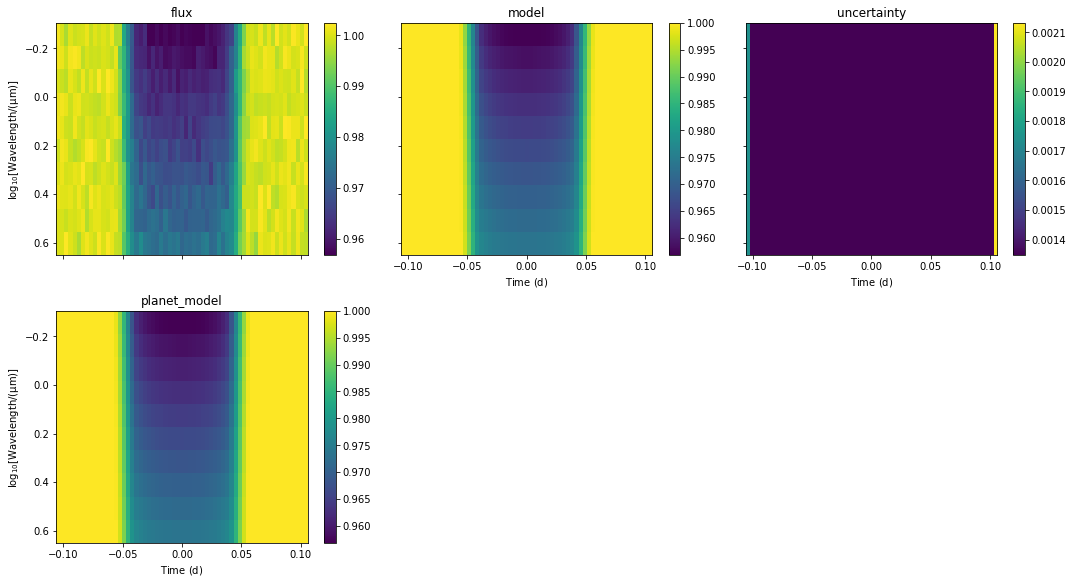

In [2]:
# create transit rainbow:
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)

# add transit (with depth varying with wavelength):
r = r.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r.nwave),
        P=1.0,
        t0=0.0,
        baseline=1.0
    )

# bin into 10 wavelength bins:
nw = 10
rb = r.bin(nwavelengths=int(r.nwave/nw), dt=5 * u.minute)

# show the simulated dataset
rb.imshow_quantities();

In [3]:
rb

<Simulated🌈(10w, 61t)>

## Define a PyMC3 Transit Model

Now onto `chromatic_fitting`. First we need to create a transit model.

In [42]:
# create transit model:
t = TransitModel()

Then we will want to decide how our parameters will vary. We can see the parameters that we will need to provide to the model. **Warning:** if we dont set any of these parameters then they will take on default values.

In [43]:
t.required_parameters

['stellar_radius',
 'stellar_mass',
 'radius_ratio',
 'period',
 'epoch',
 'baseline',
 'impact_parameter',
 'limb_darkening']

In [44]:
t.defaults

{'stellar_radius': 1.0,
 'stellar_mass': 1.0,
 'radius_ratio': 1.0,
 'period': 1.0,
 'epoch': 0.0,
 'baseline': 1.0,
 'impact_parameter': 0.5,
 'eccentricity': 0.0,
 'omega': 0,
 'limb_darkening': [0.2, 0.2]}

Usually when we're fitting a transit we'll have some idea about the transit parameters (from previous literature or just looking at the lightcurves by eye), so it's a good idea to give good initial estimates to help our sampling converge nicely. Here we're defining the prior distributions for each parameter. There are four options for parameters in `chromatic_fitting`: `Fixed`, `WavelikeFixed`, `Fitted`, and `WavelikeFitted`. `Fixed` is one value fixed across all wavelengths, `WavelikeFixed` are fixed values that can vary between wavelengths. `Fitted` determines a prior distribution (e.g. `Uniform`, `Normal`, `TruncatedNormal`) that we will use to fit one value for the parameter across all wavelengths. Similarly, `WavelikeFitted` is a prior distribution that we will use to fit for a different value for every wavelength. 

In [45]:
# add our parameters:
t.setup_parameters(
                  period=1.0, # a fixed value!
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.17, sigma=0.05), # a different value fitted for every wavelength!
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(Uniform,testval=[0.2,0.2], shape=2),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.05), 
                )

# print a summary of all params:
t.summarize_parameters()

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.17, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1.0 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 WavelikeFitted Normal(mu=1.0, sigma=0.05, name='transit_baseline') for each wavelength 🧮>

transit_impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='transit_impact_parameter') 🧮>

transit_eccentricity =
  <🧮 Fixed | 0.0 🧮>

transit_omega =
  <🧮 Fixed | 0 🧮>

transit_limb_darkening =
  <🧮 WavelikeFitted Uniform(testval=[0.2, 0.2], shape=2, name='transit_limb_darkening') for each wavelength 🧮>



## Attach the Rainbow Object and Set-up the Model

The next step is to attach the actual data to the model and setup the lightcurves!

In [46]:
# attach the Rainbow object to the model:
t.attach_data(rb)

# this is the last point where we can change the optimization method:
t.choose_optimization_method("separate") # other options: white_light, simultaneous

# setup the lightcurves for the transit model & 
# relate the "actual" data to the model (using a Normal likelihood function)
t.setup_likelihood()

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:208: UserWarning: transit in the parameter name: transit_stellar_radius. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
  0%|                                                                               | 0/10 [00:00<?, ?it/s]

.setup_lightcurves() has not been run yet, running now...


 10%|███████                                                                | 1/10 [00:00<00:06,  1.43it/s]

.setup_lightcurves() has not been run yet, running now...


 20%|██████████████▏                                                        | 2/10 [00:01<00:05,  1.43it/s]

.setup_lightcurves() has not been run yet, running now...


 30%|█████████████████████▎                                                 | 3/10 [00:02<00:07,  1.05s/it]

.setup_lightcurves() has not been run yet, running now...


 40%|████████████████████████████▍                                          | 4/10 [00:03<00:05,  1.09it/s]

.setup_lightcurves() has not been run yet, running now...


 50%|███████████████████████████████████▌                                   | 5/10 [00:04<00:04,  1.19it/s]

.setup_lightcurves() has not been run yet, running now...


 60%|██████████████████████████████████████████▌                            | 6/10 [00:04<00:03,  1.27it/s]

.setup_lightcurves() has not been run yet, running now...


 70%|█████████████████████████████████████████████████▋                     | 7/10 [00:05<00:02,  1.31it/s]

.setup_lightcurves() has not been run yet, running now...


 80%|████████████████████████████████████████████████████████▊              | 8/10 [00:06<00:01,  1.34it/s]

.setup_lightcurves() has not been run yet, running now...


 90%|███████████████████████████████████████████████████████████████▉       | 9/10 [00:07<00:00,  1.37it/s]

.setup_lightcurves() has not been run yet, running now...


100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


If we look at our `PyMC3` model we can see that it has a lot of parameters to optimize! If we've chosen the separate wavelength fitting method (`.choose_optimization_method("separate")`) then `._pymc3_model` will return a list of PyMC3 models (one for each wavelength).

In [47]:
t._pymc3_model

We've got our transit parameters that are wavelength-independant in this case (`epoch, impact_parameter, stellar_radius, stellar_mass, a_R*, limb_darkening`) and the wavelength-dependant parameters we've defined to be `radius_ratio` and `baseline` only. The `data` parameter just represents the fit of the data to the model at each wavelength (which we've defined to be a Normal distribution). If we've set `store_models = True` at the `.setup_lightcurves()` stage then we will also see a bunch of models!

Now we can plot a couple of priors (samples from our prior distribution) - do they look OK?

100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.35s/it]


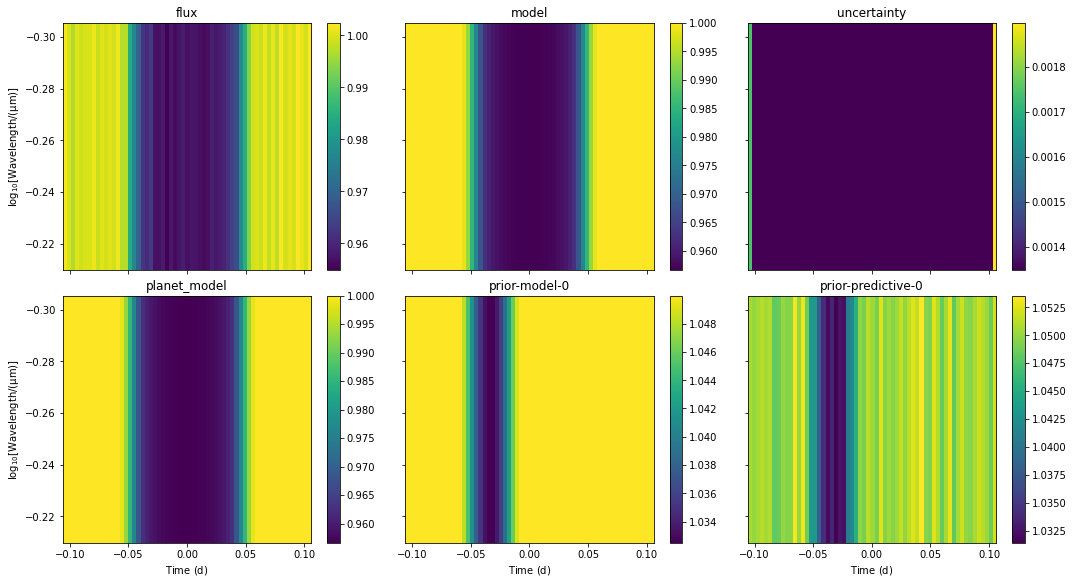

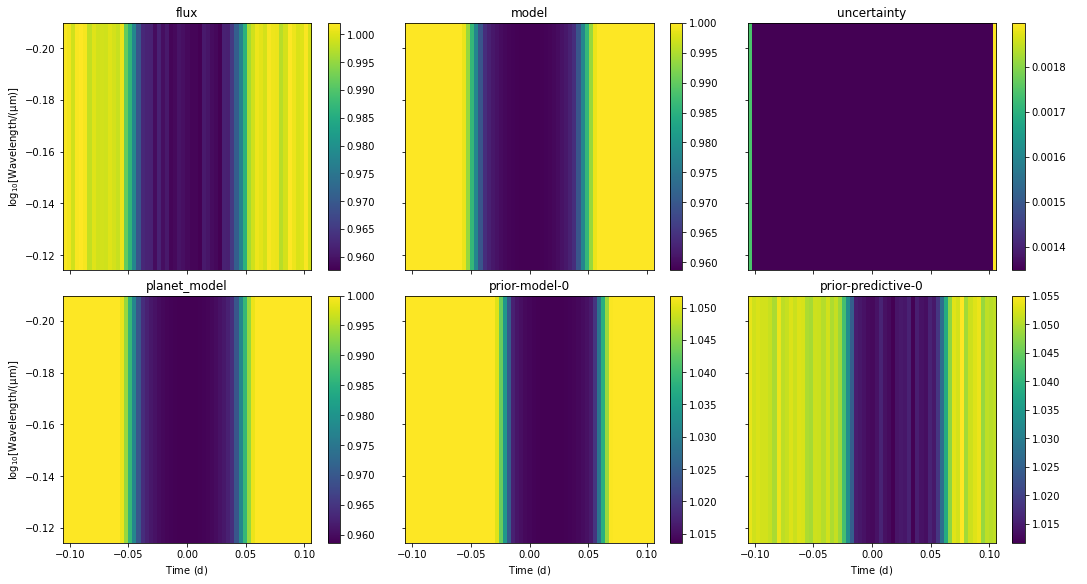

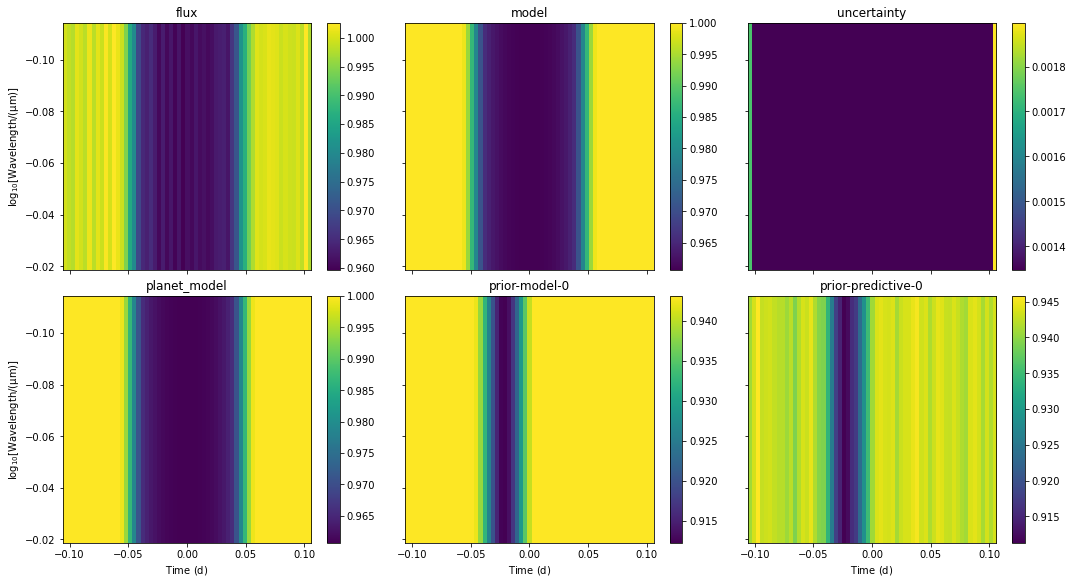

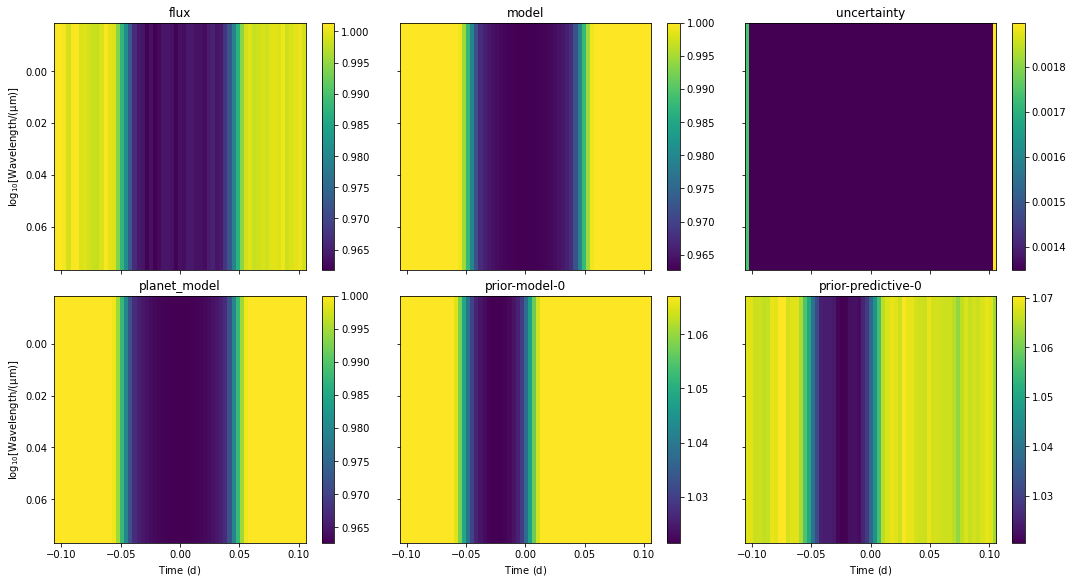

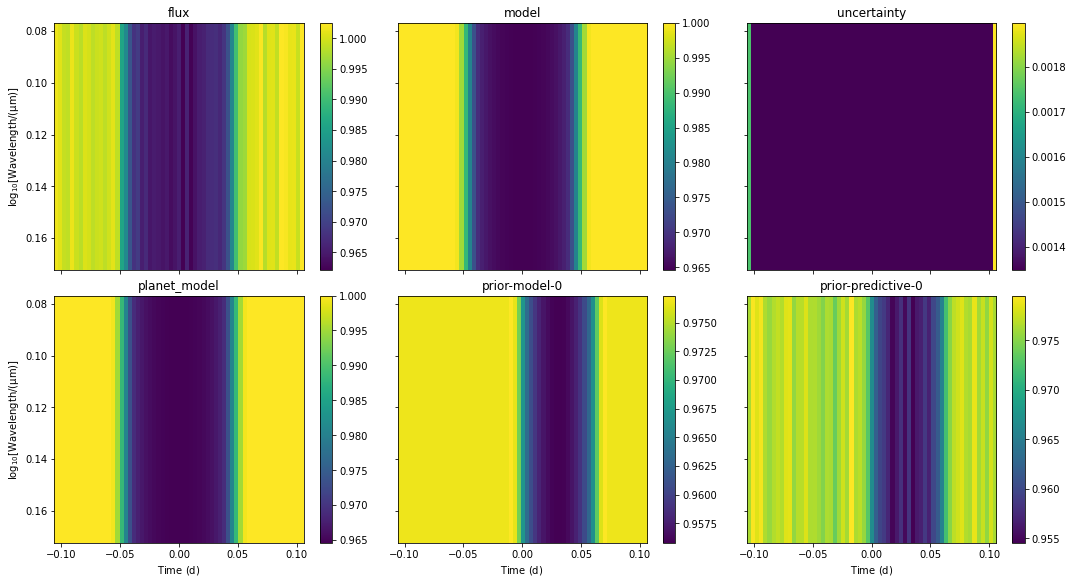

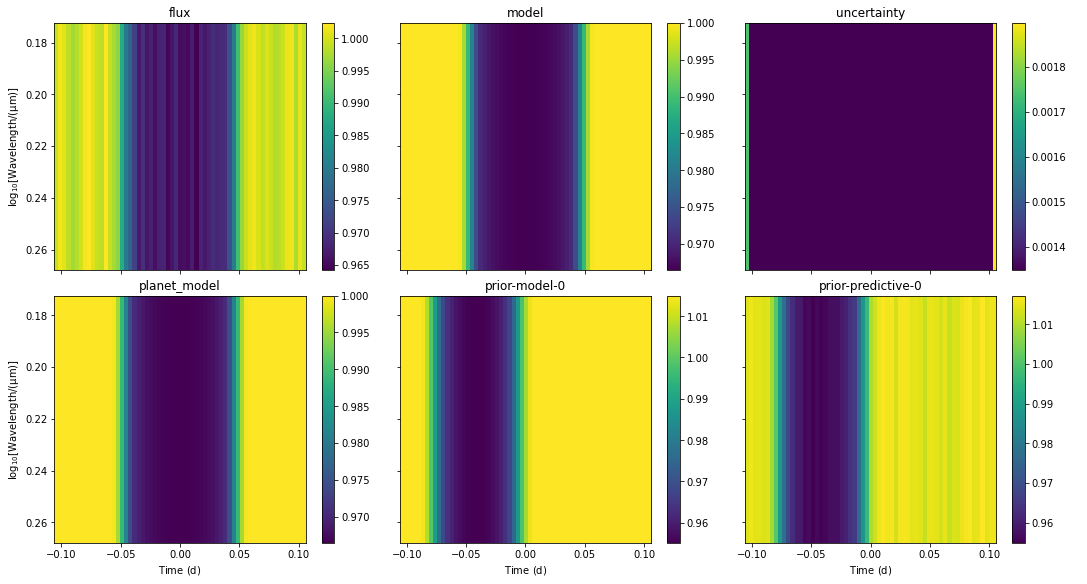

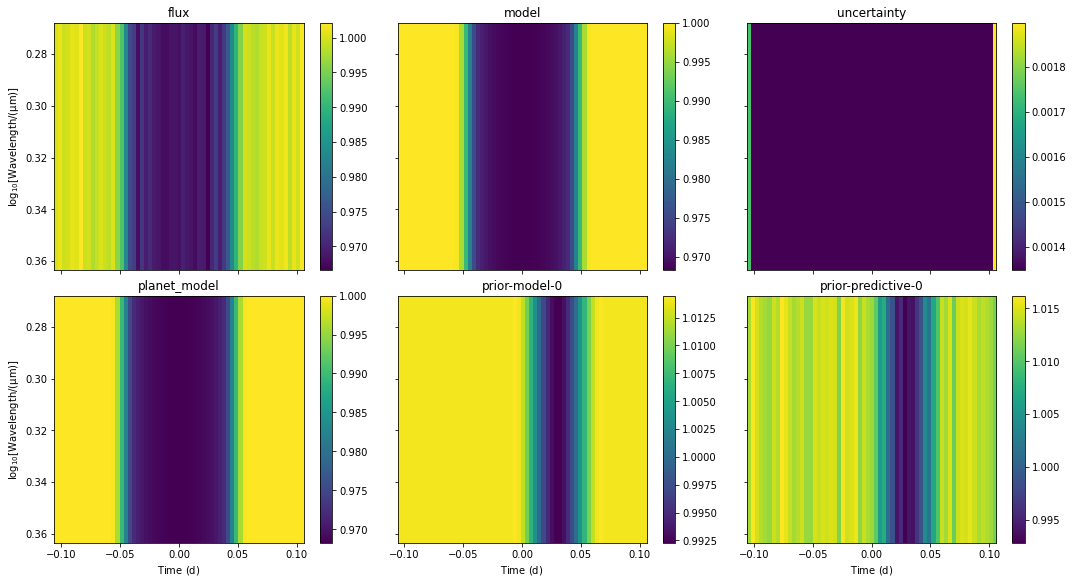

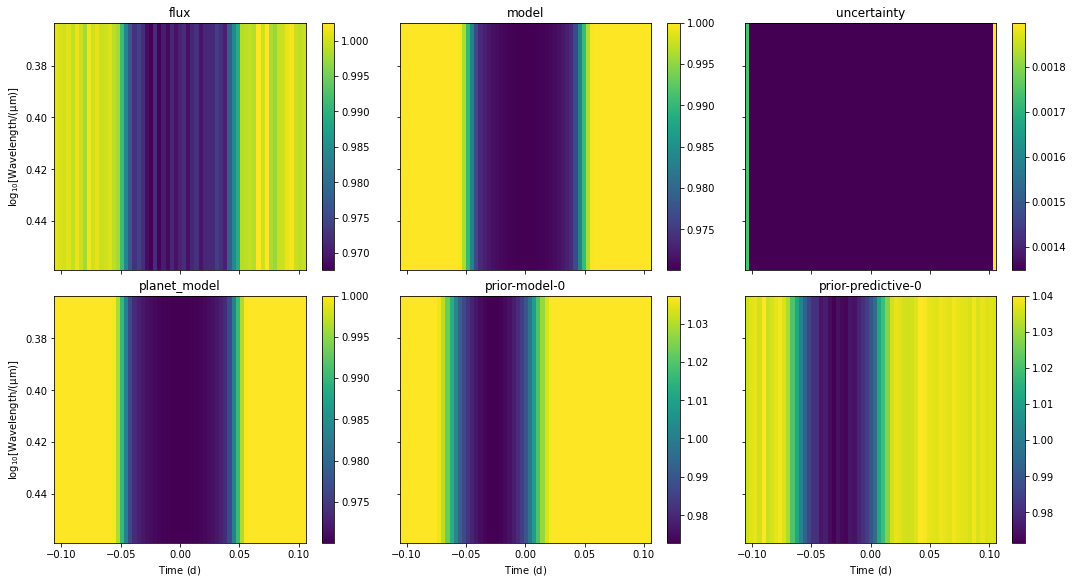

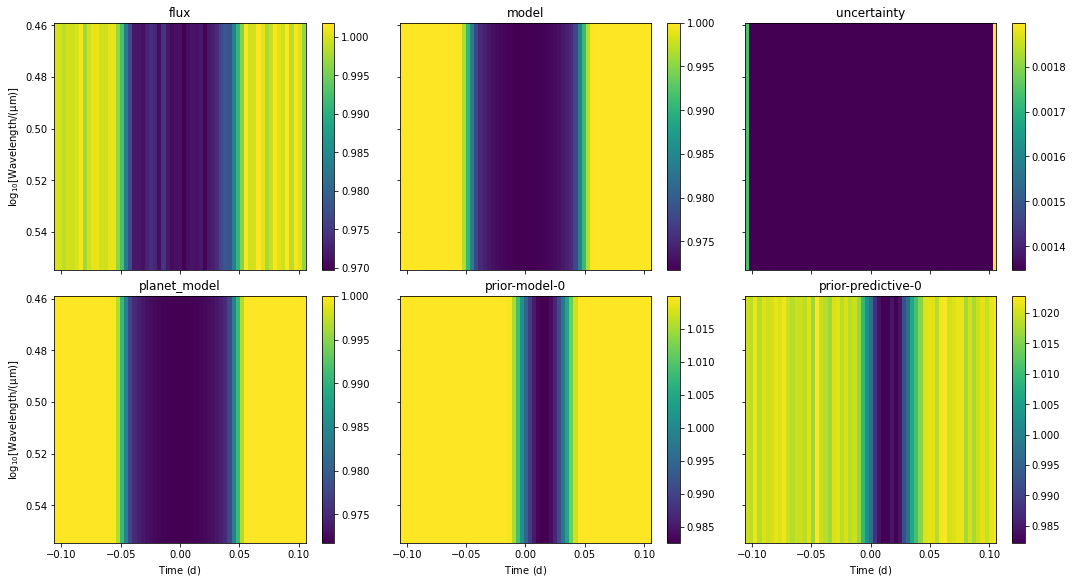

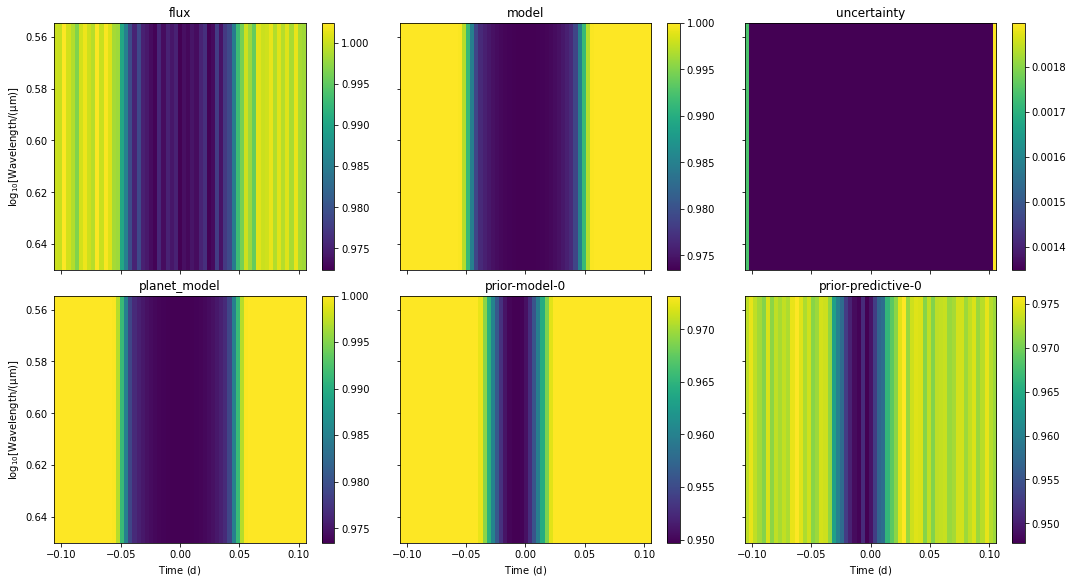

In [48]:
# t.apply_operation_to_constituent_models('plot_priors')()
t.plot_priors(n=1)

Plotting the priors can be reassuring for two reasons: (1) we're not giving priors that are vastly off from the true values, and (2) we're not over-constraining our model by giving it the exact solution and priors that are too tight.

Another check is does this planetary system actually transit given our parameters?

  0%|                                                                               | 0/10 [00:00<?, ?it/s]

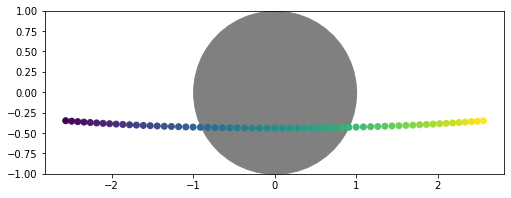

 10%|███████                                                                | 1/10 [00:00<00:02,  4.16it/s]

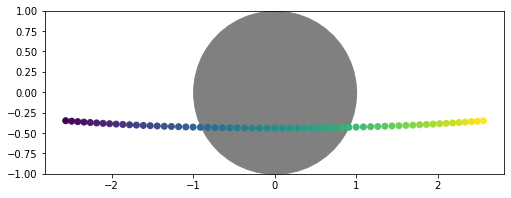

 20%|██████████████▏                                                        | 2/10 [00:00<00:01,  4.21it/s]

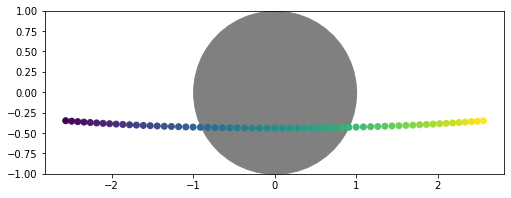

 30%|█████████████████████▎                                                 | 3/10 [00:01<00:04,  1.70it/s]

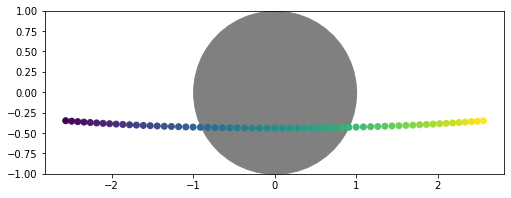

 40%|████████████████████████████▍                                          | 4/10 [00:01<00:02,  2.23it/s]

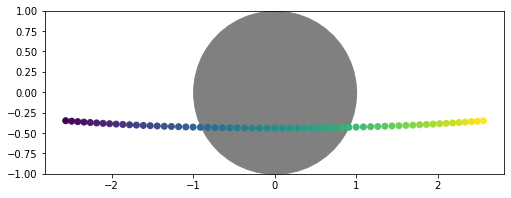

 50%|███████████████████████████████████▌                                   | 5/10 [00:01<00:01,  2.71it/s]

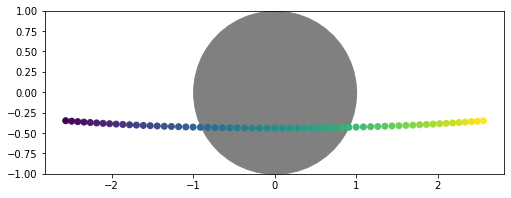

 60%|██████████████████████████████████████████▌                            | 6/10 [00:02<00:01,  3.12it/s]

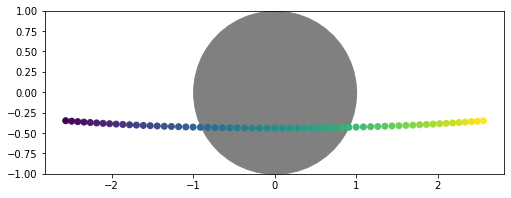

 70%|█████████████████████████████████████████████████▋                     | 7/10 [00:02<00:00,  3.42it/s]

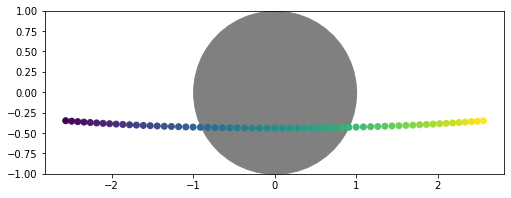

 80%|████████████████████████████████████████████████████████▊              | 8/10 [00:02<00:00,  3.68it/s]

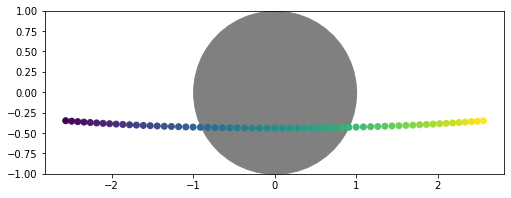

 90%|███████████████████████████████████████████████████████████████▉       | 9/10 [00:02<00:00,  3.81it/s]

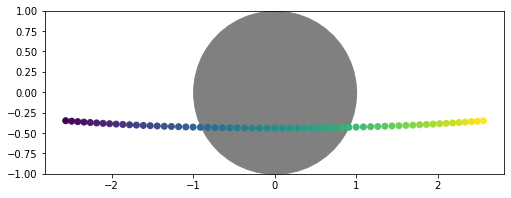

100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.21it/s]


In [49]:
t.plot_orbit()

Looks good! And a final check of what the actual lightcurves look like:

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.sample() and {self}.summarize() before calling this step!


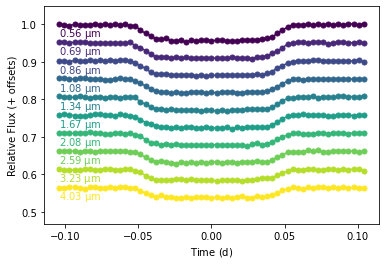

In [50]:
t.plot_lightcurves()

## PyMC3 sampling

Now we can run the NUTS sampling for our light curves (first by optimizing our initial values)

  0%|                                                                               | 0/10 [00:00<?, ?it/s]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -2693.889028506436 -> 302.3931265307486


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 10%|███████                                                                | 1/10 [00:02<00:21,  2.40s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -2285.2591060206996 -> 312.2824672789696


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 20%|██████████████▏                                                        | 2/10 [00:05<00:22,  2.84s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1856.5864886901295 -> 313.0722681852425


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 30%|█████████████████████▎                                                 | 3/10 [00:07<00:17,  2.56s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1545.728414897817 -> 322.1660246600008


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 40%|████████████████████████████▍                                          | 4/10 [00:10<00:16,  2.74s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1275.061033294891 -> 308.0534082315146


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 50%|███████████████████████████████████▌                                   | 5/10 [00:13<00:12,  2.59s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1045.1284933324941 -> 305.8115580639871


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 60%|██████████████████████████████████████████▌                            | 6/10 [00:16<00:11,  2.77s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Optimization terminated successfully.
logp: -772.9406257269936 -> 313.37724937637887


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 70%|█████████████████████████████████████████████████▋                     | 7/10 [00:18<00:07,  2.57s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -645.9424433963334 -> 304.5012896225017


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 80%|████████████████████████████████████████████████████████▊              | 8/10 [00:21<00:05,  2.68s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -562.1740111008379 -> 306.7234379602826


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 90%|███████████████████████████████████████████████████████████████▉       | 9/10 [00:23<00:02,  2.57s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -482.08892946132306 -> 301.31257578837085


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:568: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.67s/it]


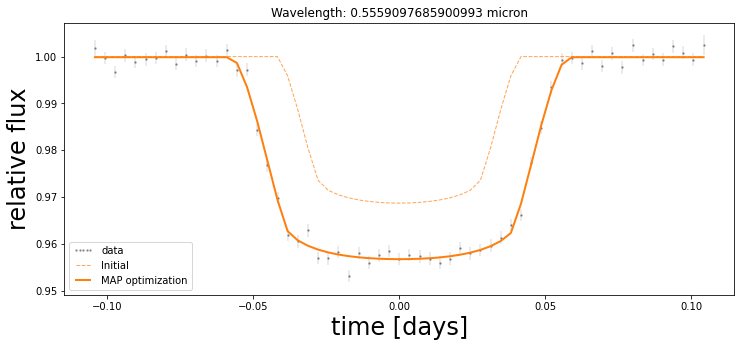

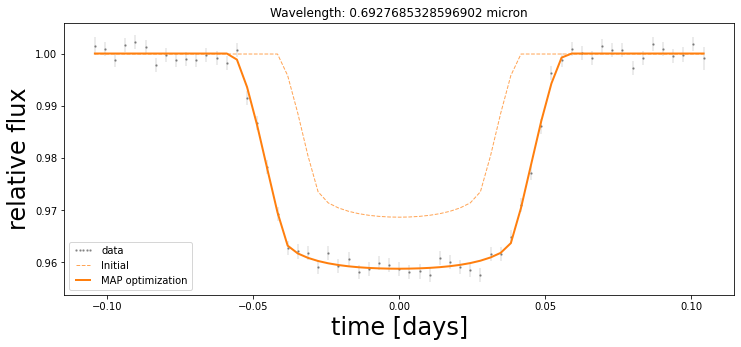

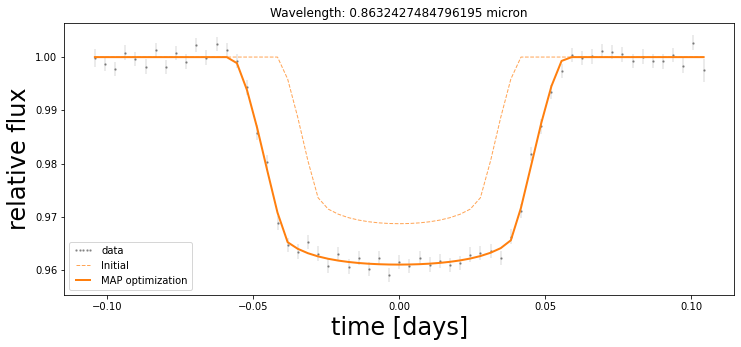

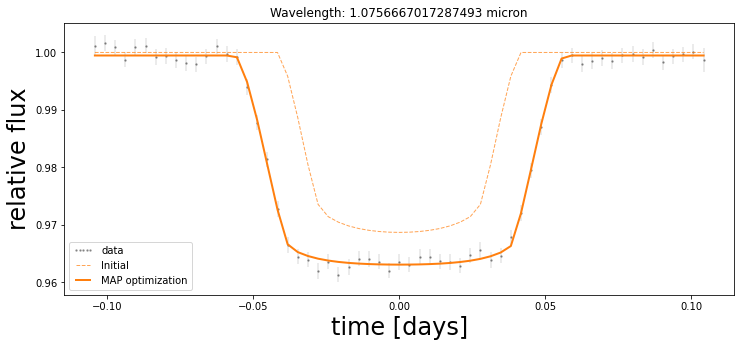

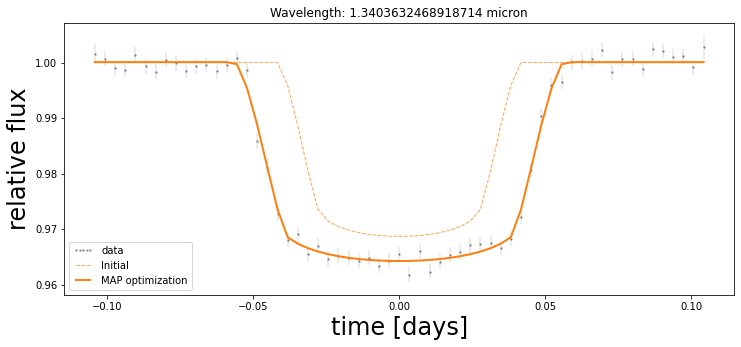

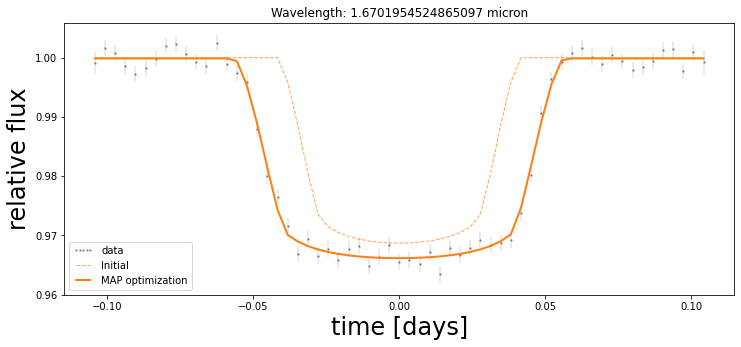

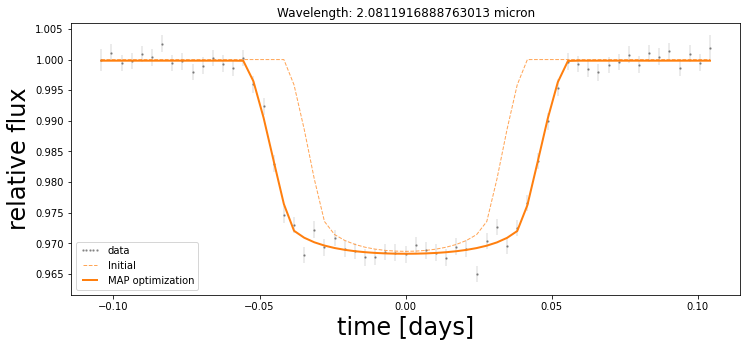

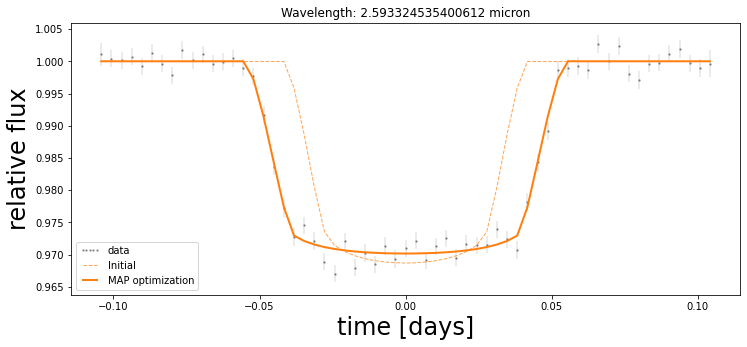

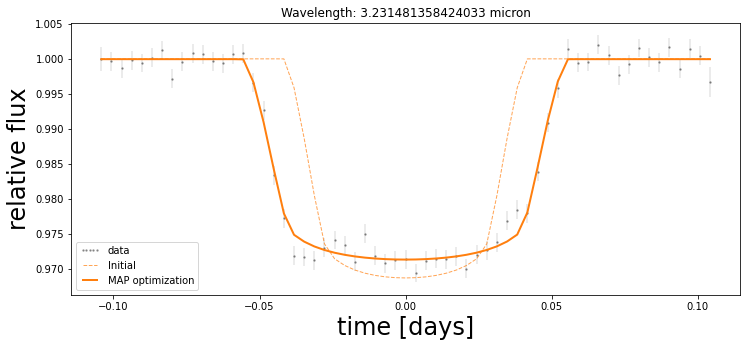

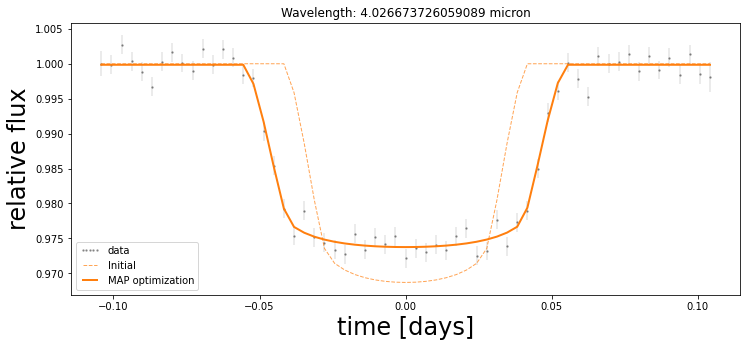

In [51]:
# optimize for initial values!
opt = t.optimize(plot=True)

In [52]:
# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains. NOTE: if you do separate wavelength fitting then the number of steps 
# is per wavelengths, not divided between the wavelengths!
t.sample(use_optimized_start_point=True, tune=2000, draws=2000, chains=4, cores=4) #start=opt, 

  0%|                                                                               | 0/10 [00:00<?, ?it/s]

Sampling model using the <function sample at 0x284db23a0> method
Using MAP-optimized start point...


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 60 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.197163  0.001862  0.195341  0.198988   
transit_baseline[0]           0.999869  0.000254  0.999631  1.000132   
transit_epoch[0]              0.000173  0.000199 -0.000010  0.000384   
transit_impact_parameter[0]   0.081042  0.057459  0.000416  0.102965   
transit_stellar_radius[0]     1.181128  0.012895  1.175825  1.199910   
transit_stellar_mass[0]       0.844843  0.029470  0.800276  0.858133   
transit_limb_darkening[0, 0]  0.149619  0.083129  0.038358  0.221638   
transit_limb_darkening[0, 1]  0.300926  0.182609  0.027955  0.408206   
transit_a_R*[0]               3.367899  0.032970  3.336725  3.402940   
transit_planet_radius[0]      0.232871  0.003038  0.229708  0.235924   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000043  0.000030  1858.114785  2255.426937   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 60 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.195324  0.001832  0.193556  0.197268   
transit_baseline[0]           1.000096  0.000249  0.999840  1.000337   
transit_epoch[0]             -0.000187  0.000203 -0.000396  0.000009   
transit_impact_parameter[0]   0.107264  0.068826  0.002726  0.142664   
transit_stellar_radius[0]     1.177857  0.014339  1.170008  1.198691   
transit_stellar_mass[0]       0.853171  0.032193  0.807382  0.872039   
transit_limb_darkening[0, 0]  0.115371  0.071668  0.016650  0.162737   
transit_limb_darkening[0, 1]  0.228217  0.151599  0.000281  0.297458   
transit_a_R*[0]               3.388262  0.034606  3.359430  3.428494   
transit_planet_radius[0]      0.230060  0.003231  0.227015  0.233866   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000046  0.000032  1543.492217  1601.135275   
transit_baseline[0]            0.000005  0.000004

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 59 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.189133  0.001793  0.187700  0.191173   
transit_baseline[0]           0.999991  0.000262  0.999686  1.000215   
transit_epoch[0]             -0.000217  0.000225 -0.000449 -0.000004   
transit_impact_parameter[0]   0.115820  0.072512  0.006570  0.157792   
transit_stellar_radius[0]     1.180825  0.013215  1.175380  1.199929   
transit_stellar_mass[0]       0.844368  0.030038  0.802094  0.858826   
transit_limb_darkening[0, 0]  0.135160  0.076076  0.045711  0.208872   
transit_limb_darkening[0, 1]  0.228617  0.155833  0.000004  0.295561   
transit_a_R*[0]               3.368150  0.036218  3.335878  3.408701   
transit_planet_radius[0]      0.223330  0.003129  0.220304  0.226774   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000053  0.000038  1090.332074   435.542969   
transit_baseline[0]            0.000006  0.000004

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 64 seconds.
There were 173 divergences after tuning. Increase `target_accept` or reparameter

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.184736  0.001934  0.183035  0.186918   
transit_baseline[0]           0.999492  0.000257  0.999271  0.999766   
transit_epoch[0]              0.000163  0.000228 -0.000073  0.000391   
transit_impact_parameter[0]   0.152293  0.088906  0.024851  0.228091   
transit_stellar_radius[0]     1.179180  0.014839  1.172858  1.199675   
transit_stellar_mass[0]       0.847999  0.033711  0.800686  0.861540   
transit_limb_darkening[0, 0]  0.072930  0.054734  0.000450  0.088662   
transit_limb_darkening[0, 1]  0.235347  0.145394  0.050573  0.347079   
transit_a_R*[0]               3.377659  0.044289  3.341366  3.430165   
transit_planet_radius[0]      0.217837  0.003572  0.214257  0.221809   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000113  0.000080   272.803544   287.669736   
transit_baseline[0]            0.000008  0.000005

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 91 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.180665  0.001744  0.179169  0.182520   
transit_baseline[0]           1.000078  0.000257  0.999842  1.000352   
transit_epoch[0]              0.000013  0.000238 -0.000233  0.000237   
transit_impact_parameter[0]   0.091366  0.064158  0.000779  0.117757   
transit_stellar_radius[0]     1.177412  0.014175  1.169493  1.198406   
transit_stellar_mass[0]       0.850746  0.032691  0.802092  0.866567   
transit_limb_darkening[0, 0]  0.178559  0.079060  0.107064  0.269561   
transit_limb_darkening[0, 1]  0.175704  0.140739  0.000024  0.215477   
transit_a_R*[0]               3.386290  0.034229  3.353972  3.422318   
transit_planet_radius[0]      0.212713  0.003030  0.209831  0.216110   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000057  0.000041  1042.966679   423.643151   
transit_baseline[0]            0.000005  0.000004

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 73 seconds.
There were 102 divergences after tuning. Increase `target_accept` or reparameter

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.175045  0.001895  0.173448  0.177027   
transit_baseline[0]           0.999863  0.000253  0.999628  1.000126   
transit_epoch[0]             -0.000074  0.000245 -0.000324  0.000159   
transit_impact_parameter[0]   0.108584  0.073262  0.000428  0.142571   
transit_stellar_radius[0]     1.181094  0.013502  1.175948  1.199997   
transit_stellar_mass[0]       0.840638  0.029718  0.800248  0.852257   
transit_limb_darkening[0, 0]  0.147467  0.082660  0.041867  0.223394   
transit_limb_darkening[0, 1]  0.253779  0.171126  0.005738  0.328858   
transit_a_R*[0]               3.362459  0.038022  3.323458  3.401289   
transit_planet_radius[0]      0.206740  0.002937  0.203500  0.209514   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000069  0.000049   783.513904   324.239676   
transit_baseline[0]            0.000006  0.000004

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 59 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameter

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.169388  0.001906  0.167662  0.171402   
transit_baseline[0]           0.999826  0.000253  0.999587  1.000088   
transit_epoch[0]              0.000047  0.000257 -0.000217  0.000289   
transit_impact_parameter[0]   0.107204  0.072496  0.000012  0.140615   
transit_stellar_radius[0]     1.177723  0.015002  1.171108  1.199299   
transit_stellar_mass[0]       0.851520  0.034055  0.800195  0.866178   
transit_limb_darkening[0, 0]  0.132710  0.081721  0.000168  0.171248   
transit_limb_darkening[0, 1]  0.276051  0.175580  0.002605  0.356526   
transit_a_R*[0]               3.386445  0.039683  3.349953  3.430622   
transit_planet_radius[0]      0.199488  0.003117  0.196608  0.203041   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000048  0.000034  1488.425321   825.931399   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 57 seconds.
There were 94 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.166786  0.001739  0.165241  0.168643   
transit_baseline[0]           1.000028  0.000245  0.999754  1.000243   
transit_epoch[0]              0.000014  0.000265 -0.000241  0.000293   
transit_impact_parameter[0]   0.121927  0.078232  0.000210  0.160018   
transit_stellar_radius[0]     1.173664  0.018029  1.165747  1.199871   
transit_stellar_mass[0]       0.860207  0.040720  0.801022  0.879805   
transit_limb_darkening[0, 0]  0.107706  0.069220  0.006658  0.143539   
transit_limb_darkening[0, 1]  0.199220  0.139435  0.005827  0.255844   
transit_a_R*[0]               3.409496  0.044416  3.374988  3.461994   
transit_planet_radius[0]      0.195747  0.003431  0.192089  0.199387   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000045  0.000032  1450.591159  1690.230760   
transit_baseline[0]            0.000005  0.000004

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 59 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.160702  0.001843  0.158945  0.162672   
transit_baseline[0]           0.999953  0.000250  0.999725  1.000214   
transit_epoch[0]             -0.000055  0.000275 -0.000309  0.000230   
transit_impact_parameter[0]   0.101852  0.068988  0.004226  0.137086   
transit_stellar_radius[0]     1.180864  0.013406  1.175486  1.199995   
transit_stellar_mass[0]       0.842266  0.029345  0.800293  0.854298   
transit_limb_darkening[0, 0]  0.176399  0.089832  0.091463  0.284909   
transit_limb_darkening[0, 1]  0.238548  0.168529  0.000484  0.305556   
transit_a_R*[0]               3.365286  0.036975  3.330084  3.404826   
transit_planet_radius[0]      0.189763  0.002740  0.187201  0.192840   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000037  0.000026  2394.173798  2326.092525   
transit_baseline[0]            0.000004  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 60 seconds.
There were 140 divergences after tuning. Increase `target_accept` or reparameter

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.154197  0.001991  0.152120  0.156037   
transit_baseline[0]           0.999862  0.000249  0.999617  1.000116   
transit_epoch[0]             -0.000051  0.000294 -0.000325  0.000256   
transit_impact_parameter[0]   0.108974  0.071366  0.002314  0.144203   
transit_stellar_radius[0]     1.180361  0.014533  1.175105  1.199811   
transit_stellar_mass[0]       0.841307  0.030371  0.800010  0.852738   
transit_limb_darkening[0, 0]  0.138496  0.085290  0.004986  0.182026   
transit_limb_darkening[0, 1]  0.256664  0.176991  0.001357  0.331655   
transit_a_R*[0]               3.365492  0.042026  3.327001  3.414233   
transit_planet_radius[0]      0.182001  0.002839  0.179224  0.185056   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000051  0.000036  1490.441117  1047.803098   
transit_baseline[0]            0.000005  0.000004

100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.31s/it]


At this stage the sampler may print out some warnings that we don't have enough tuning steps! Also be aware this step can be quite slow depending on how many parameters we're trying to fit at once (which may increase with the number of wavelengths). We can then see the results of our sampling by running `.summarize()`:

In [53]:
t.summary

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
transit_radius_ratio[0],0.197163,0.001862,0.195341,0.198988,0.000043,0.000030,1858.114785,2255.426937,1.000675
transit_baseline[0],0.999869,0.000254,0.999631,1.000132,0.000005,0.000003,3065.006682,2635.063021,1.001675
transit_epoch[0],0.000173,0.000199,-0.000010,0.000384,0.000004,0.000003,2433.060690,2163.843898,1.000914
transit_impact_parameter[0],0.081042,0.057459,0.000416,0.102965,0.001684,0.001393,1127.360499,698.986751,1.001600
transit_stellar_radius[0],1.181128,0.012895,1.175825,1.199910,0.000421,0.000298,824.002363,828.248790,1.003675
...,...,...,...,...,...,...,...,...,...
transit_stellar_mass[9],0.841307,0.030371,0.800010,0.852738,0.000744,0.000526,1180.555396,825.654992,1.002882
"transit_limb_darkening[9, 0]",0.138496,0.085290,0.004986,0.182026,0.002331,0.001649,1229.798486,1413.301701,1.006968
"transit_limb_darkening[9, 1]",0.256664,0.176991,0.001357,0.331655,0.005090,0.003600,896.180970,589.146240,1.007336
transit_a_R*[9],3.365492,0.042026,3.327001,3.414233,0.001248,0.000883,1103.294279,1048.754492,1.003640


An important parameter to look out for here to check whether your samplings have converged is [`r_hat`](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html#arviz.rhat). This [rank normalized R-hat diagnostic](https://arxiv.org/abs/1903.08008) tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identicalm therefore, the closer it is to 1 the better the chance that your sampling successfully converged. If you're interested in the sampling see the [`PyMC3 docs`](https://docs.pymc.io/en/v3/index.html) for much more detail!

In [54]:
np.all(t.summary['r_hat'].values < 1.05) # check the convergence is good!

True

We might also want to see a couple of posterior samples as a "quick-look" check! **But beware** if you've chosen the "separate" optimization method then it will plot the posteriors for every wavelength!):

  0%|                                                                               | 0/10 [00:00<?, ?it/s]/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


 10%|███████                                                                | 1/10 [00:04<00:40,  4.50s/it]

 20%|██████████████▏                                                        | 2/10 [00:09<00:38,  4.86s/it]

 30%|█████████████████████▎                                                 | 3/10 [00:14<00:32,  4.68s/it]

 40%|████████████████████████████▍                                          | 4/10 [00:19<00:28,  4.80s/it]

 50%|███████████████████████████████████▌                                   | 5/10 [00:23<00:23,  4.79s/it]

 60%|██████████████████████████████████████████▌                            | 6/10 [00:29<00:20,  5.02s/it]

 70%|█████████████████████████████████████████████████▋                     | 7/10 [00:33<00:14,  4.82s/it]

 80%|████████████████████████████████████████████████████████▊              | 8/10 [00:38<00:09,  4.72s/it]

 90%|███████████████████████████████████████████████████████████████▉       | 9/10 [00:43<00:04,  4.86s/it]

100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.78s/it]


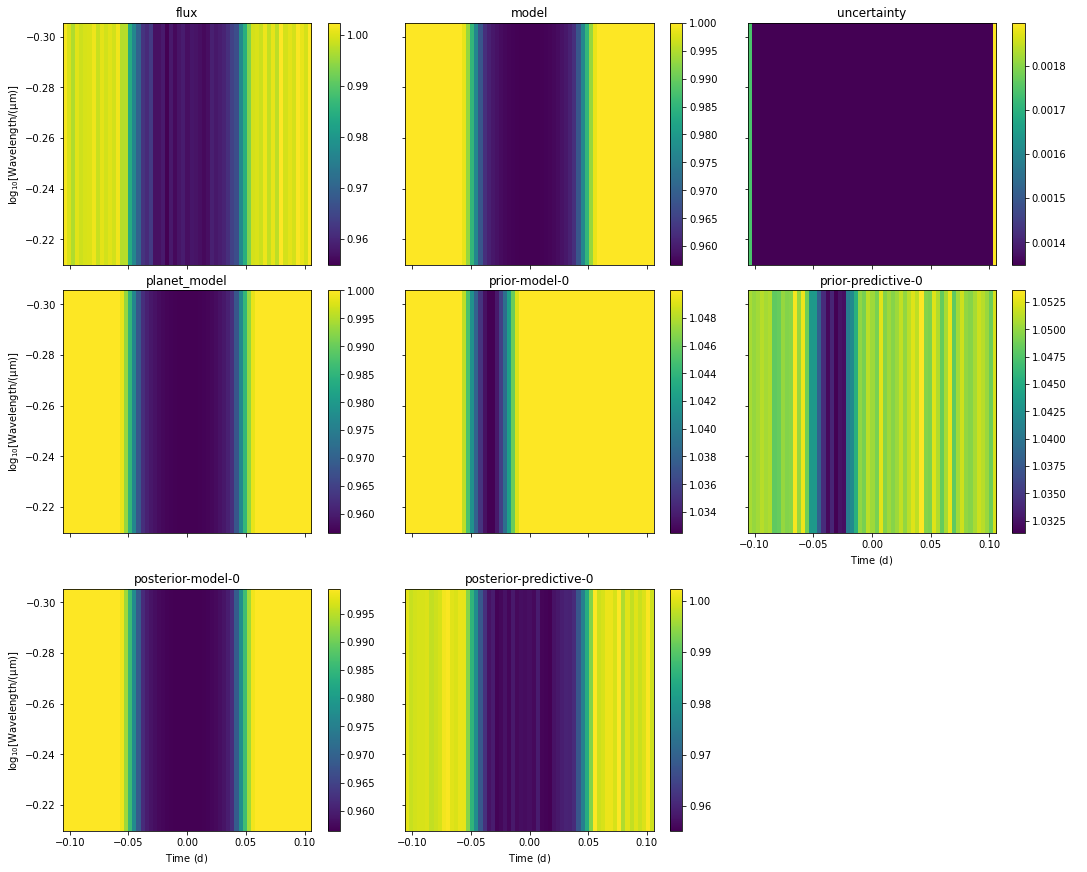

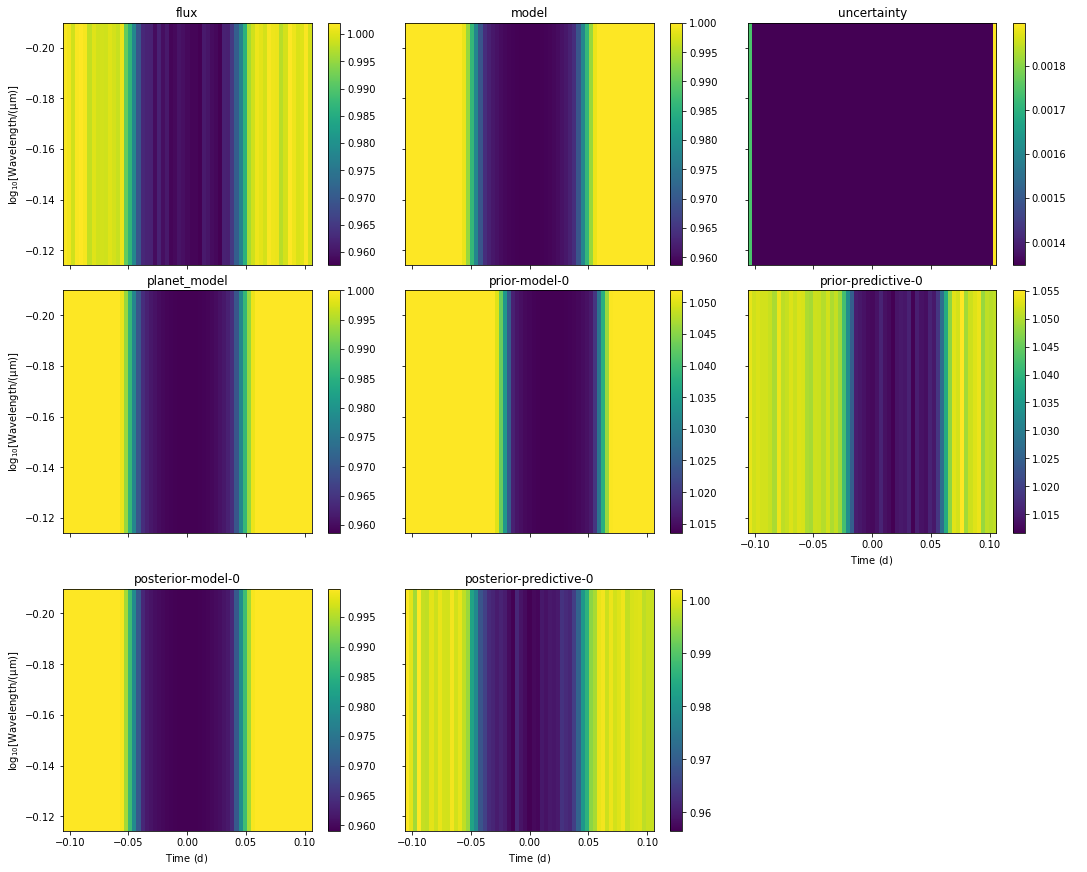

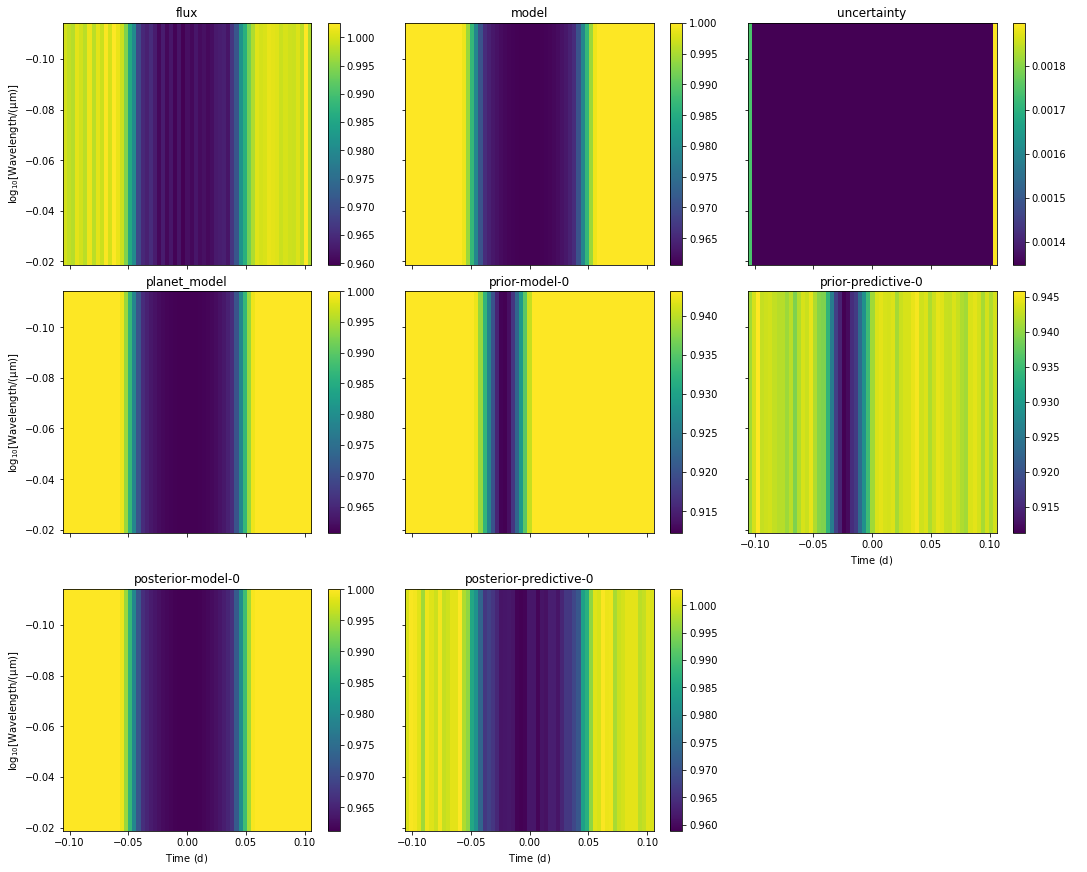

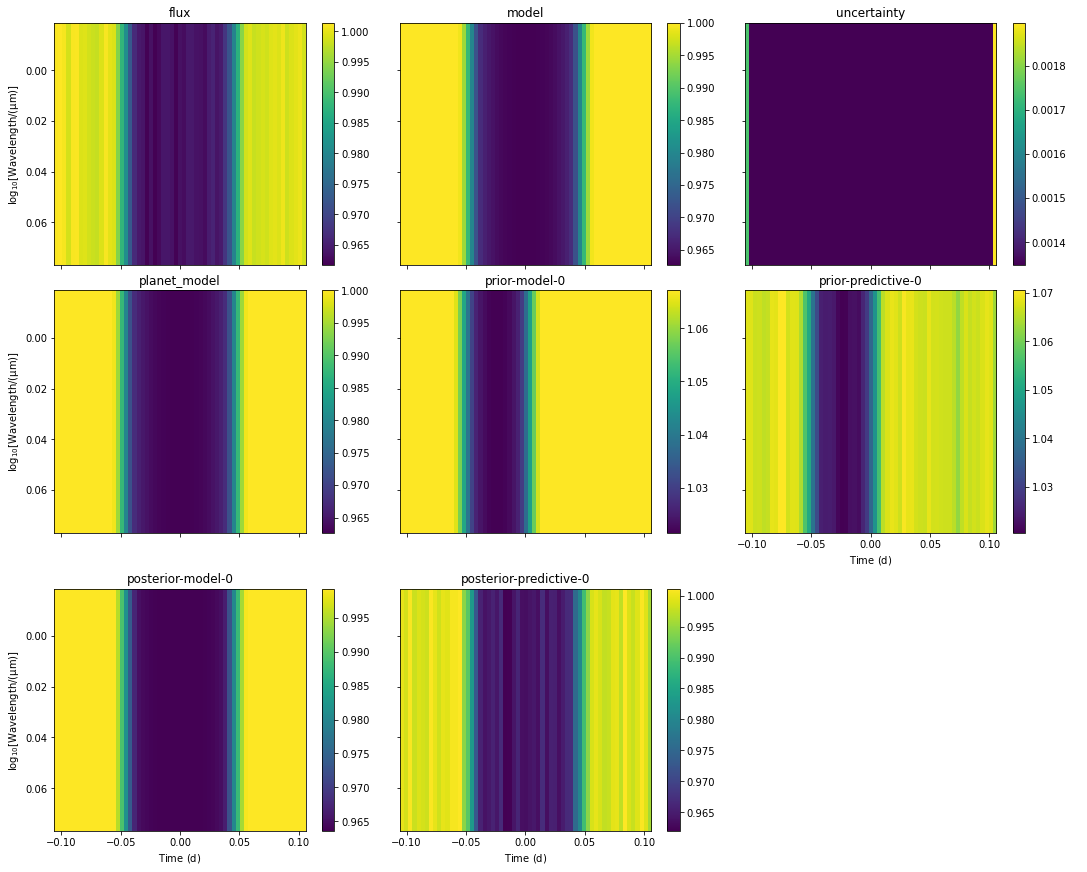

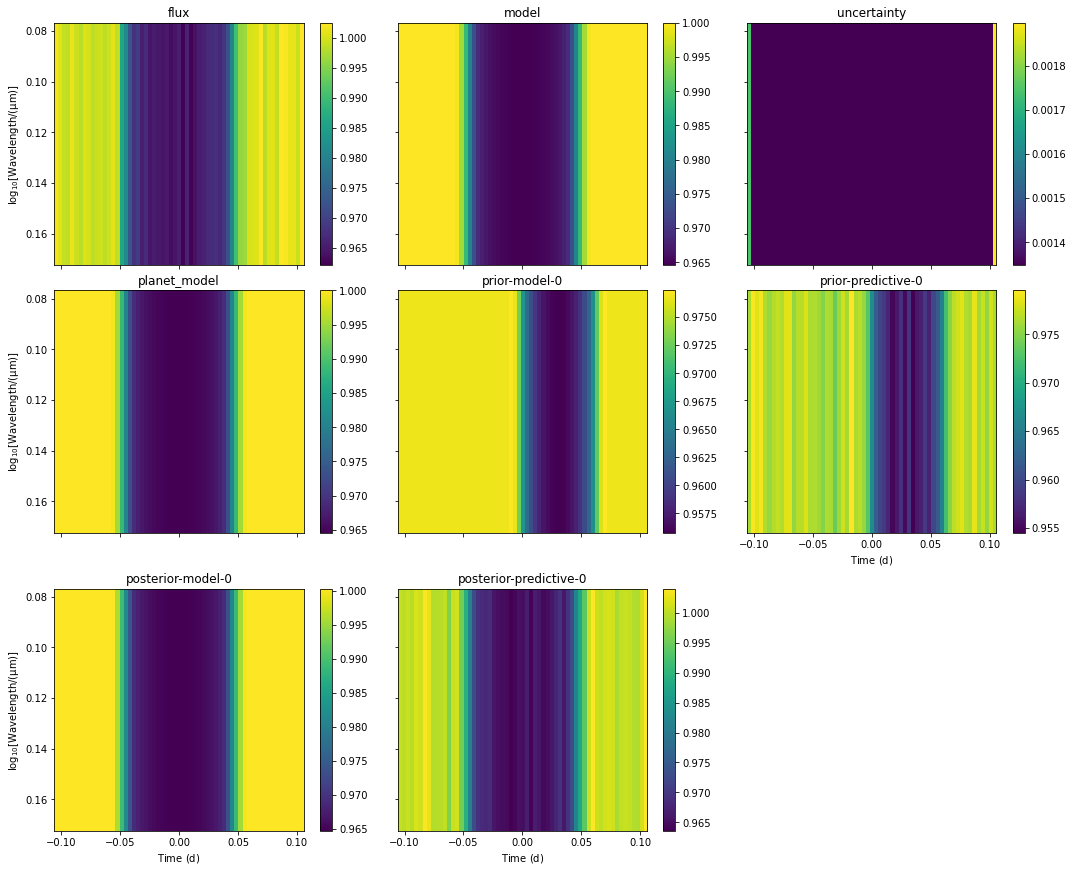

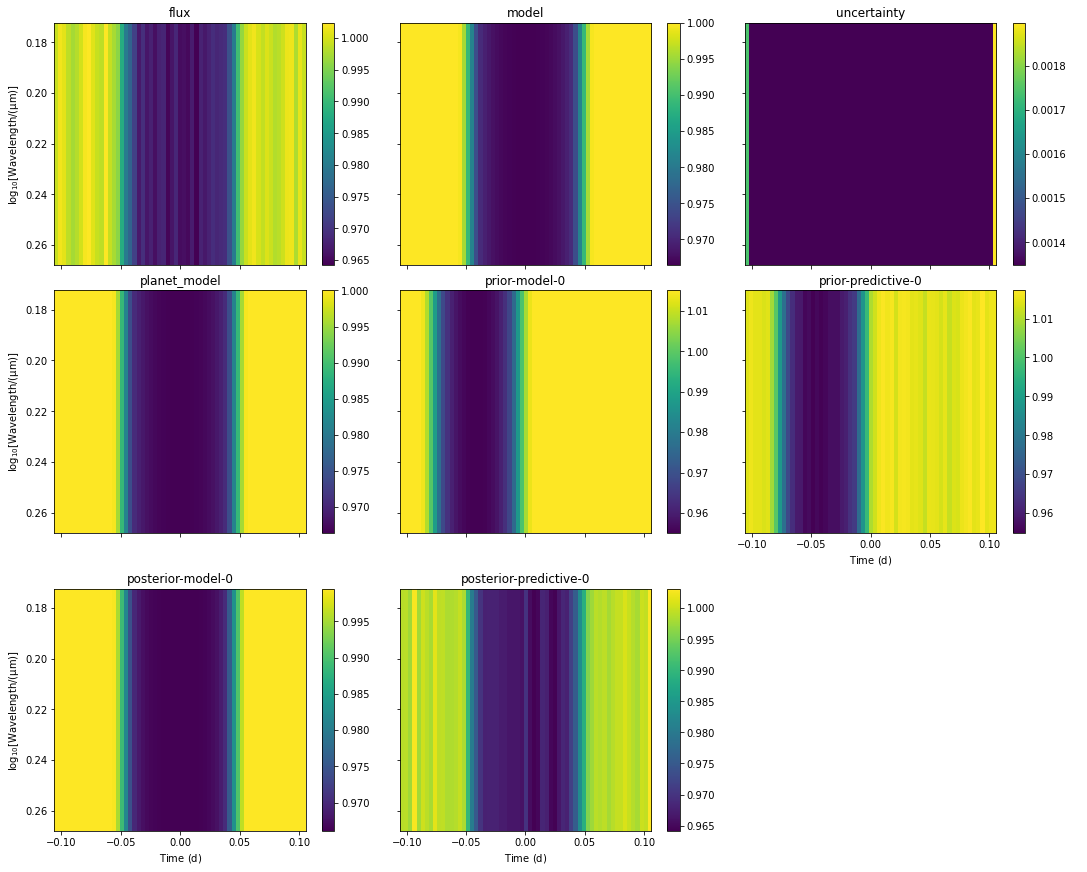

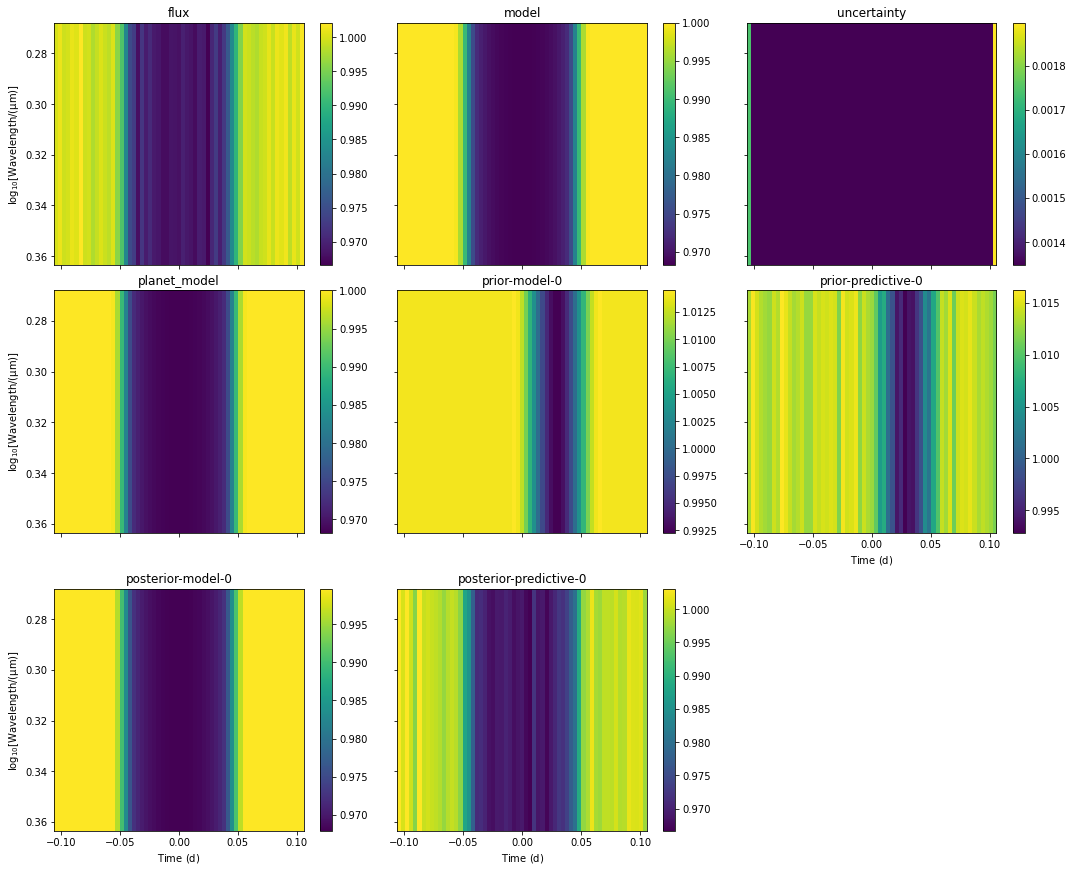

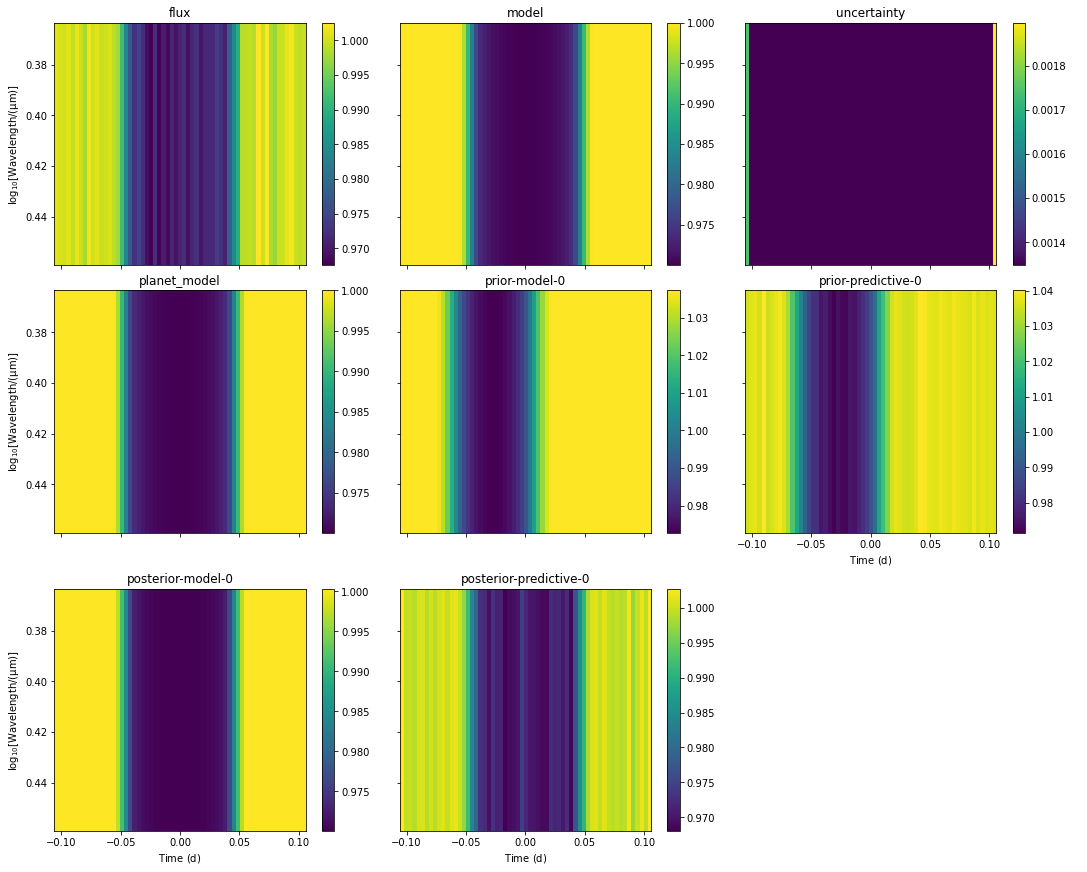

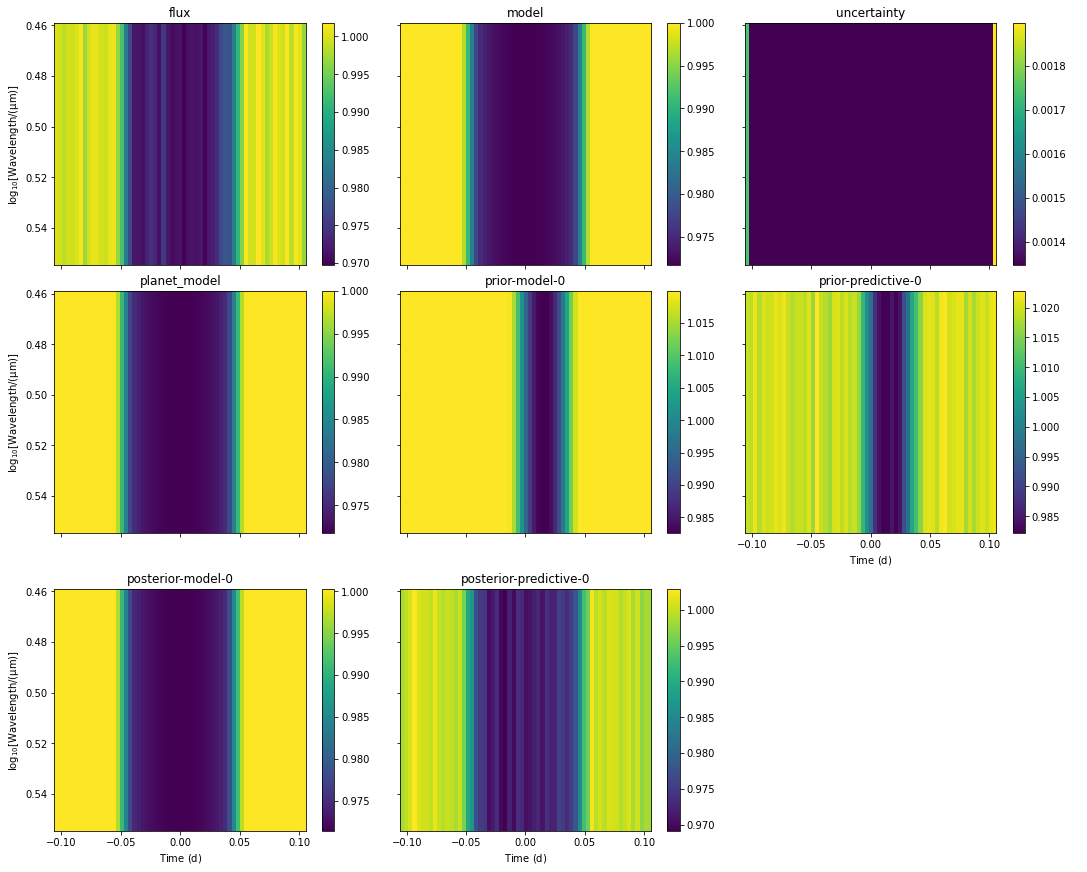

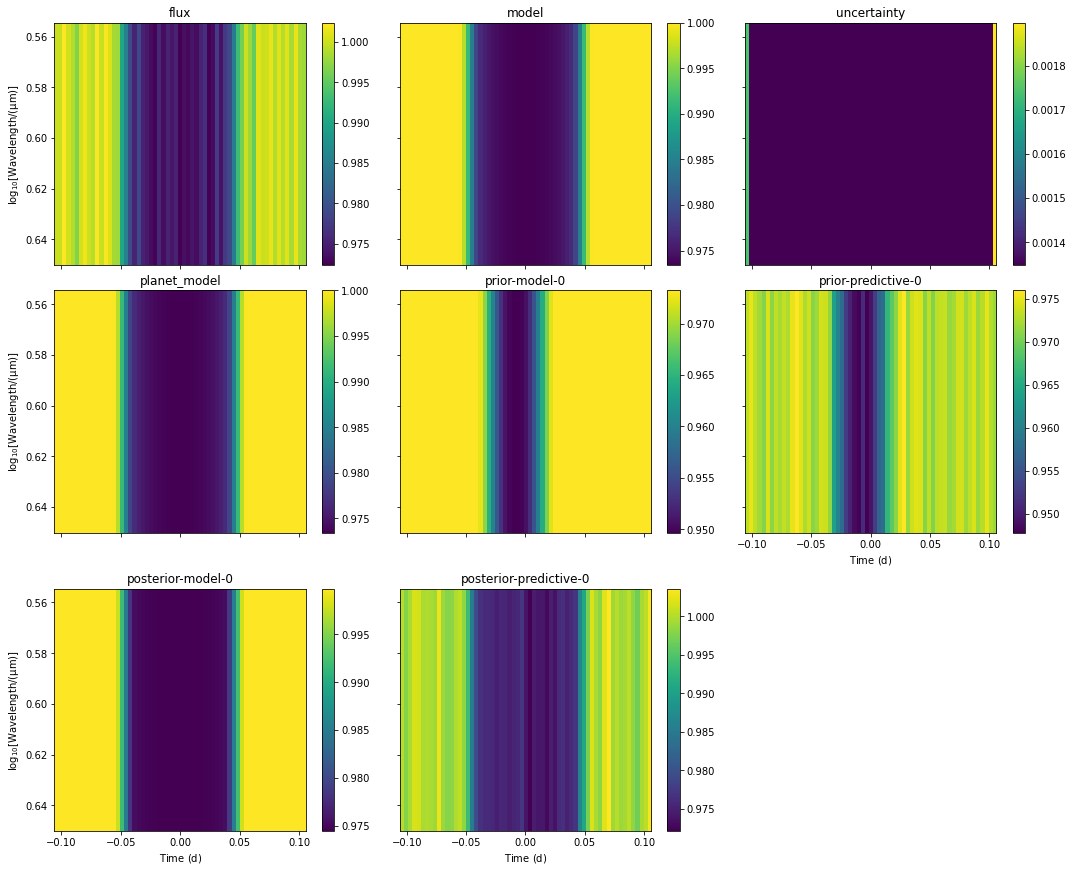

In [55]:
t.plot_posteriors(n=1)

But what are the results?? We can easily see the results using the handy `.get_results()` function:

In [56]:
t.parameters['transit_a_R*'] = []
results = t.get_results(uncertainty='sd')#['hdi_16%','hdi_84%'])

# results is a pandas dataframe, however, it doesn't show up properly on Git docs so I'll convert it to an
# astropy table
from astropy.table import Table
Table.from_pandas(results)

transit_baseline,transit_baseline_hdi_16%,transit_baseline_hdi_84%,transit_eccentricity,transit_eccentricity_hdi_16%,transit_eccentricity_hdi_84%,transit_epoch,transit_epoch_hdi_16%,transit_epoch_hdi_84%,transit_impact_parameter,transit_impact_parameter_hdi_16%,transit_impact_parameter_hdi_84%,transit_limb_darkening,transit_limb_darkening_hdi_16%,transit_limb_darkening_hdi_84%,transit_omega,transit_omega_hdi_16%,transit_omega_hdi_84%,transit_period,transit_period_hdi_16%,transit_period_hdi_84%,transit_radius_ratio,transit_radius_ratio_hdi_16%,transit_radius_ratio_hdi_84%,transit_stellar_mass,transit_stellar_mass_hdi_16%,transit_stellar_mass_hdi_84%,transit_stellar_radius,transit_stellar_radius_hdi_16%,transit_stellar_radius_hdi_84%,wavelength
object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
0.9998695,0.9996313,1.0001321,0.0,0.0,0.0,0.0001729,-9.7e-06,0.0003841,0.0810417,0.000416,0.1029647,"[0.1496186, 0.3009262]","[0.0383584, 0.0279548]","[0.2216381, 0.4082063]",0,0,0,1.0,1.0,1.0,0.1971632,0.1953411,0.198988,0.844843,0.8002765,0.8581331,1.1811284,1.1758252,1.1999104,0.5559097685900993 micron
1.0000955,0.9998404,1.0003371,0.0,0.0,0.0,-0.0001866,-0.0003965,9.4e-06,0.1072638,0.0027264,0.1426642,"[0.115371, 0.2282169]","[0.0166505, 0.0002814]","[0.1627368, 0.2974583]",0,0,0,1.0,1.0,1.0,0.1953242,0.1935563,0.1972682,0.8531707,0.8073824,0.8720385,1.1778569,1.1700083,1.1986905,0.6927685328596902 micron
0.9999911,0.9996861,1.0002149,0.0,0.0,0.0,-0.0002165,-0.0004489,-3.6e-06,0.1158204,0.0065704,0.1577915,"[0.1351601, 0.228617]","[0.0457112, 3.6e-06]","[0.2088717, 0.2955611]",0,0,0,1.0,1.0,1.0,0.1891325,0.1877004,0.1911733,0.8443676,0.8020939,0.8588261,1.1808253,1.17538,1.1999286,0.8632427484796195 micron
0.9994916,0.9992711,0.9997661,0.0,0.0,0.0,0.0001634,-7.32e-05,0.0003906,0.1522926,0.0248506,0.2280912,"[0.0729304, 0.2353472]","[0.0004503, 0.0505731]","[0.0886619, 0.3470785]",0,0,0,1.0,1.0,1.0,0.1847357,0.1830354,0.1869183,0.8479991,0.800686,0.8615401,1.1791797,1.1728579,1.1996748,1.0756667017287493 micron
1.0000779,0.9998425,1.0003525,0.0,0.0,0.0,1.34e-05,-0.0002333,0.0002365,0.0913662,0.0007785,0.1177565,"[0.1785587, 0.1757036]","[0.1070642, 2.4e-05]","[0.2695612, 0.215477]",0,0,0,1.0,1.0,1.0,0.1806646,0.1791685,0.1825197,0.8507462,0.8020919,0.8665665,1.1774123,1.1694933,1.1984065,1.3403632468918714 micron
0.9998628,0.9996281,1.0001255,0.0,0.0,0.0,-7.39e-05,-0.0003244,0.0001587,0.1085842,0.0004277,0.1425712,"[0.1474665, 0.2537785]","[0.0418674, 0.0057379]","[0.2233937, 0.3288584]",0,0,0,1.0,1.0,1.0,0.1750453,0.1734484,0.177027,0.8406382,0.8002482,0.8522572,1.1810941,1.1759484,1.1999974,1.6701954524865097 micron
0.9998258,0.999587,1.0000883,0.0,0.0,0.0,4.73e-05,-0.0002165,0.0002891,0.1072038,1.24e-05,0.1406153,"[0.1327098, 0.2760509]","[0.000168, 0.0026046]","[0.171248, 0.3565263]",0,0,0,1.0,1.0,1.0,0.1693883,0.1676619,0.1714023,0.8515201,0.8001949,0.8661778,1.1777229,1.1711084,1.1992989,2.0811916888763013 micron
1.0000279,0.9997543,1.0002428,0.0,0.0,0.0,1.38e-05,-0.0002406,0.0002932,0.1219271,0.0002104,0.160018,"[0.1077063, 0.1992202]","[0.0066584, 0.0058267]","[0.1435386, 0.255844]",0,0,0,1.0,1.0,1.0,0.166786,0.1652412,0.1686427,0.8602066,0.8010216,0.8798051,1.1736637,1.1657468,1.1998707,2.593324535400612 micron
0.9999527,0.9997249,1.000214,0.0,0.0,0.0,-5.51e-05,-0.0003086,0.00023,0.1018518,0.0042259,0.1370864,"[0.1763994, 0.2385483]","[0.0914627, 0.0004838]","[0.2849087, 0.305556]",0,0,0,1.0,1.0,1.0,0.1607022,0.1589449,0.1626725,0.8422658,0.8002927,0.8542982,1.180864,1.1754859,1.199995,3.231481358424033 micron


We can also make a transmission spectrum table using `.make_transmission_spectrum_table() `

In [57]:
transmission_spectrum = t.make_transmission_spectrum_table(uncertainty=['hdi_16%','hdi_84%'])

Table.from_pandas(transmission_spectrum)

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{name}_radius_ratio_neg_error"] = (


wavelength,transit_radius_ratio,transit_radius_ratio_neg_error,transit_radius_ratio_pos_error
object,object,object,object
0.5559097685900993 micron,0.1971632,0.001822100000000021,0.0018247999999999875
0.6927685328596902 micron,0.1953242,0.0017679000000000167,0.0019440000000000013
0.8632427484796195 micron,0.1891325,0.0014321000000000195,0.0020407999999999815
1.0756667017287493 micron,0.1847357,0.0017003000000000157,0.0021826000000000068
1.3403632468918714 micron,0.1806646,0.0014961000000000002,0.0018550999999999984
1.6701954524865097 micron,0.1750453,0.0015968999999999844,0.001981700000000003
2.0811916888763013 micron,0.1693883,0.001726399999999989,0.0020140000000000158
2.593324535400612 micron,0.166786,0.001544799999999985,0.0018567000000000167
3.231481358424033 micron,0.1607022,0.0017572999999999894,0.001970300000000008


We can also create (or call if you set `store_models=True`) the final best-fit models using the `.get_models()` function. This can take a minute if generating the models from parameters for lots of wavelengths.

In [58]:
models = t.get_model()
models.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9'])

As the `.get_model()` process can take time to generate the models, we store the models for use later...

In [59]:
t._fit_models.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9'])

## Visualizing Results

We have several different methods (mostly wrappers to `chromatic` functions) to plot the modelled results. I'll demonstrate several of them below:

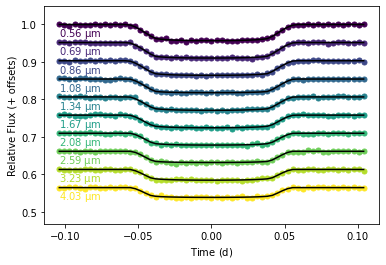

In [60]:
t.plot_lightcurves()

## Check Residuals

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.92it/s]


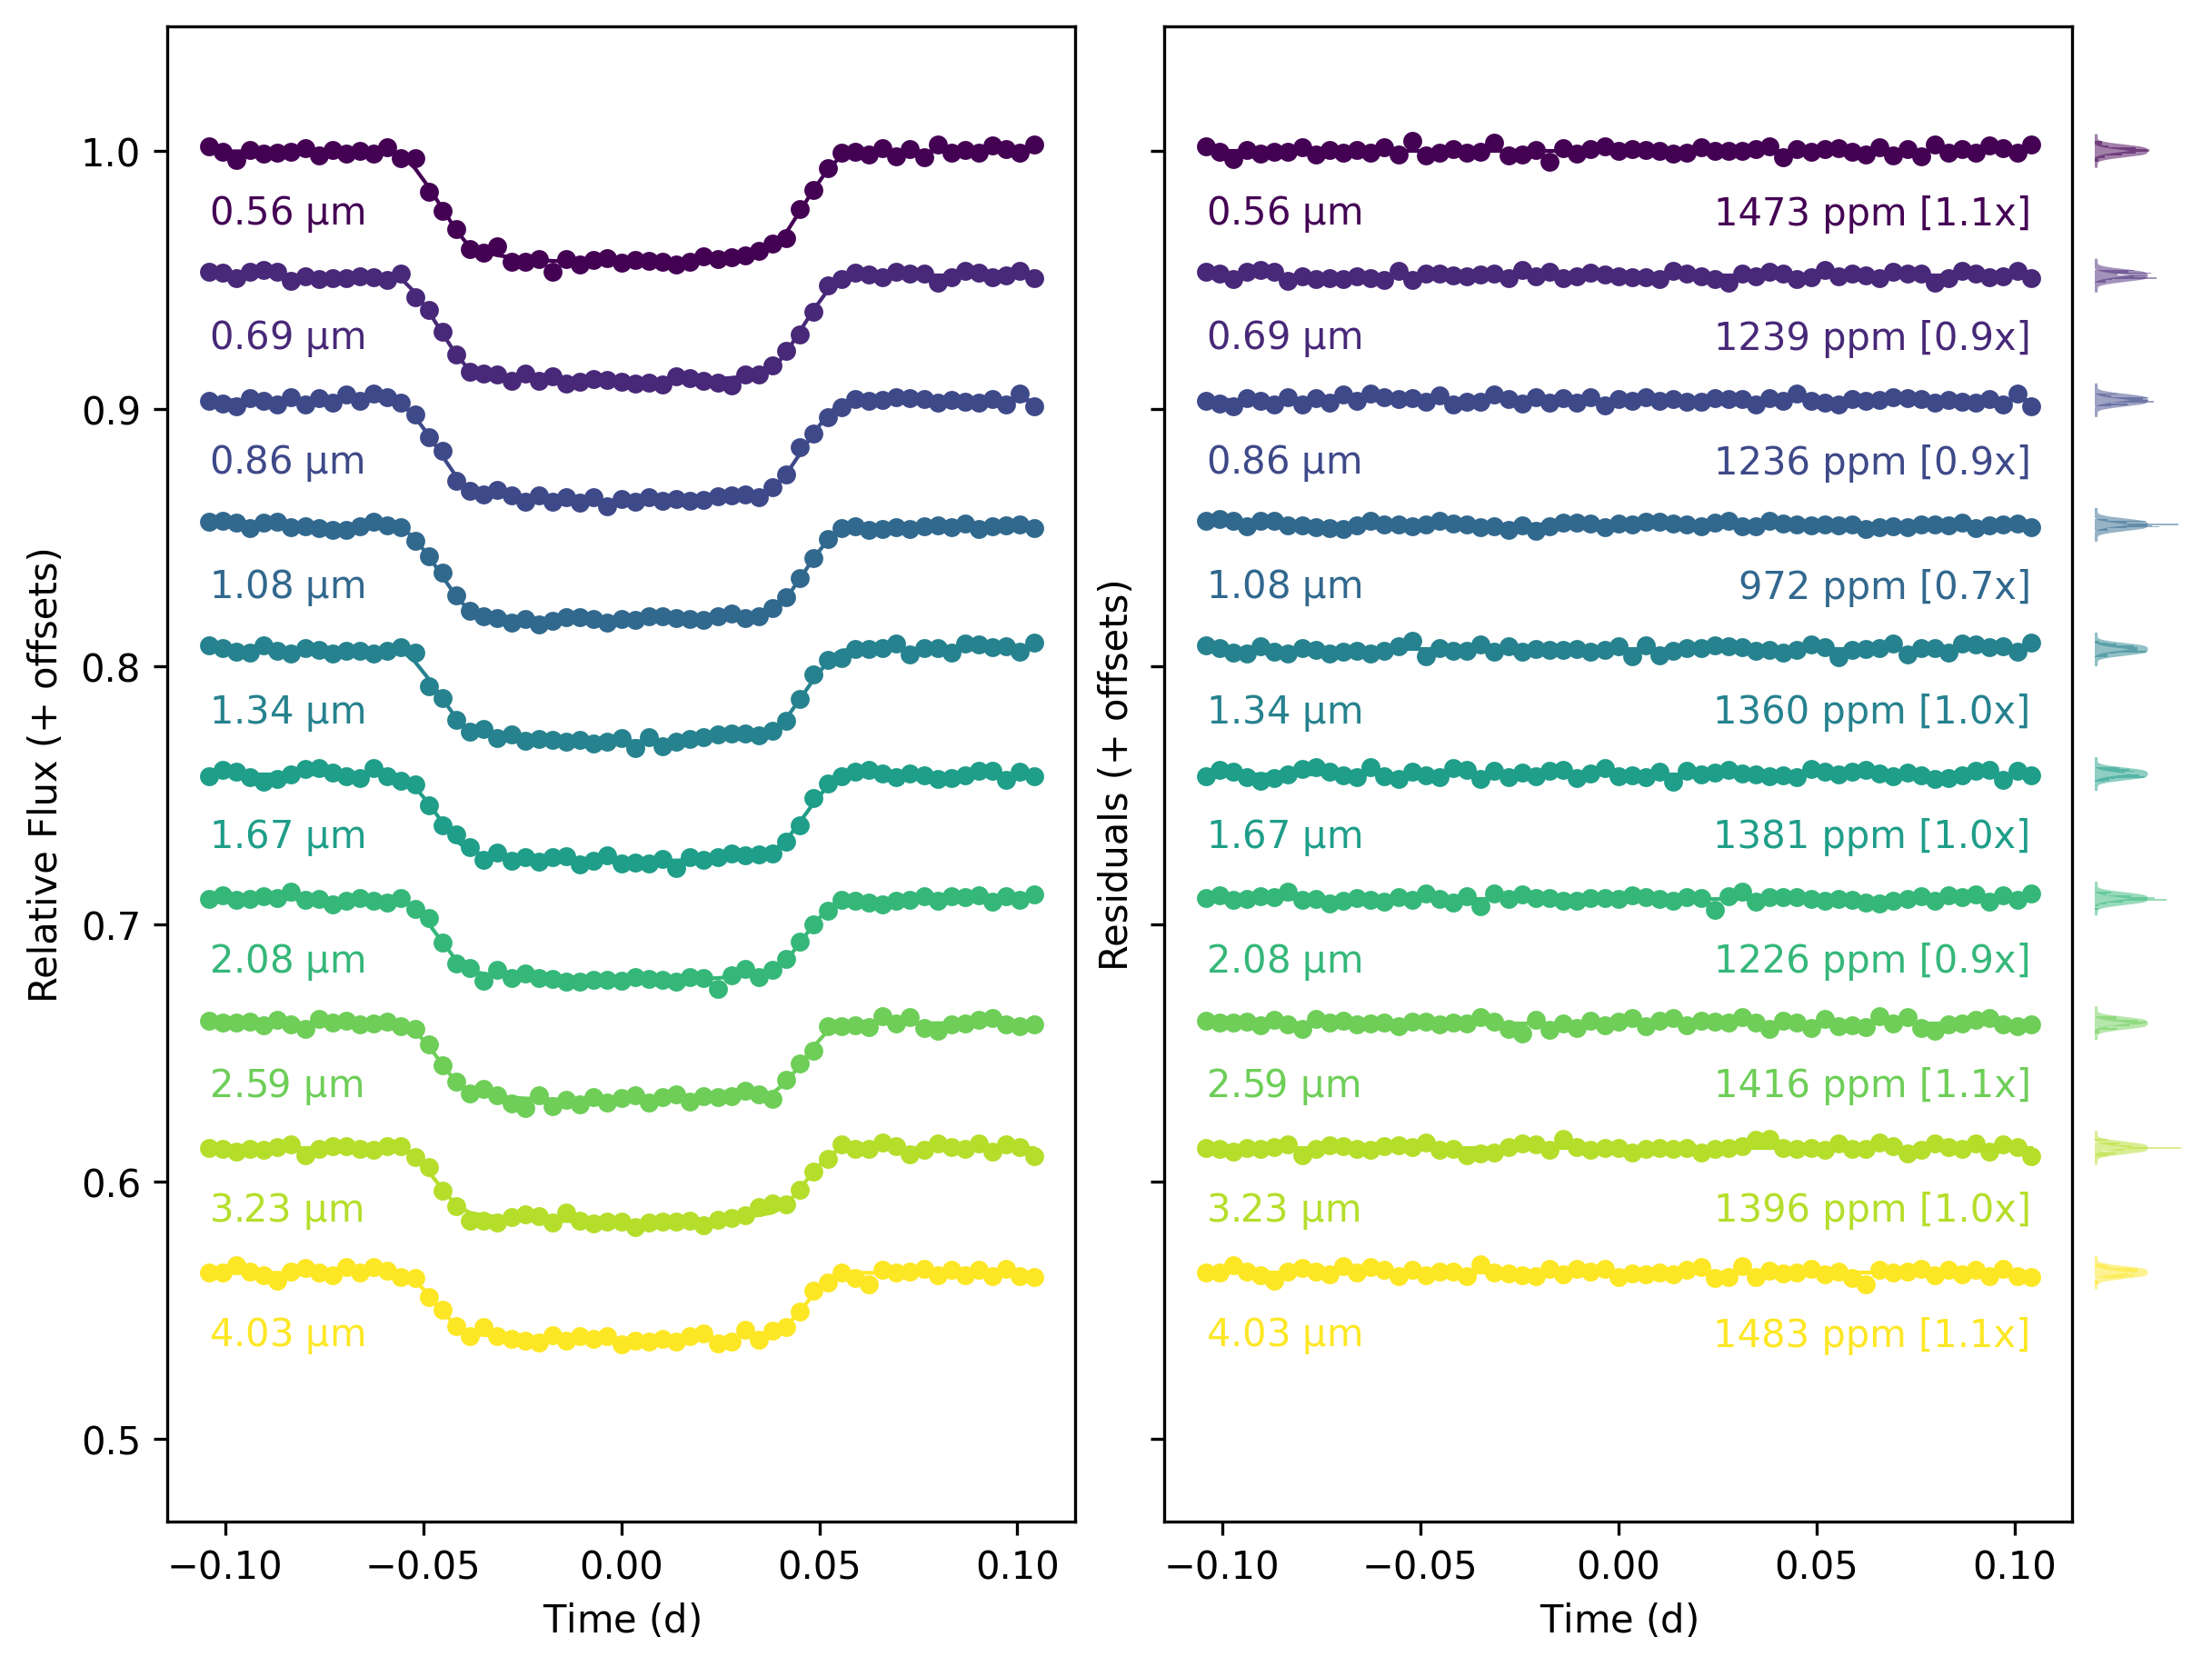

In [61]:
t.plot_with_model_and_residuals()

🌈🤖 'systematics_model' doesn't exist and will be skipped.



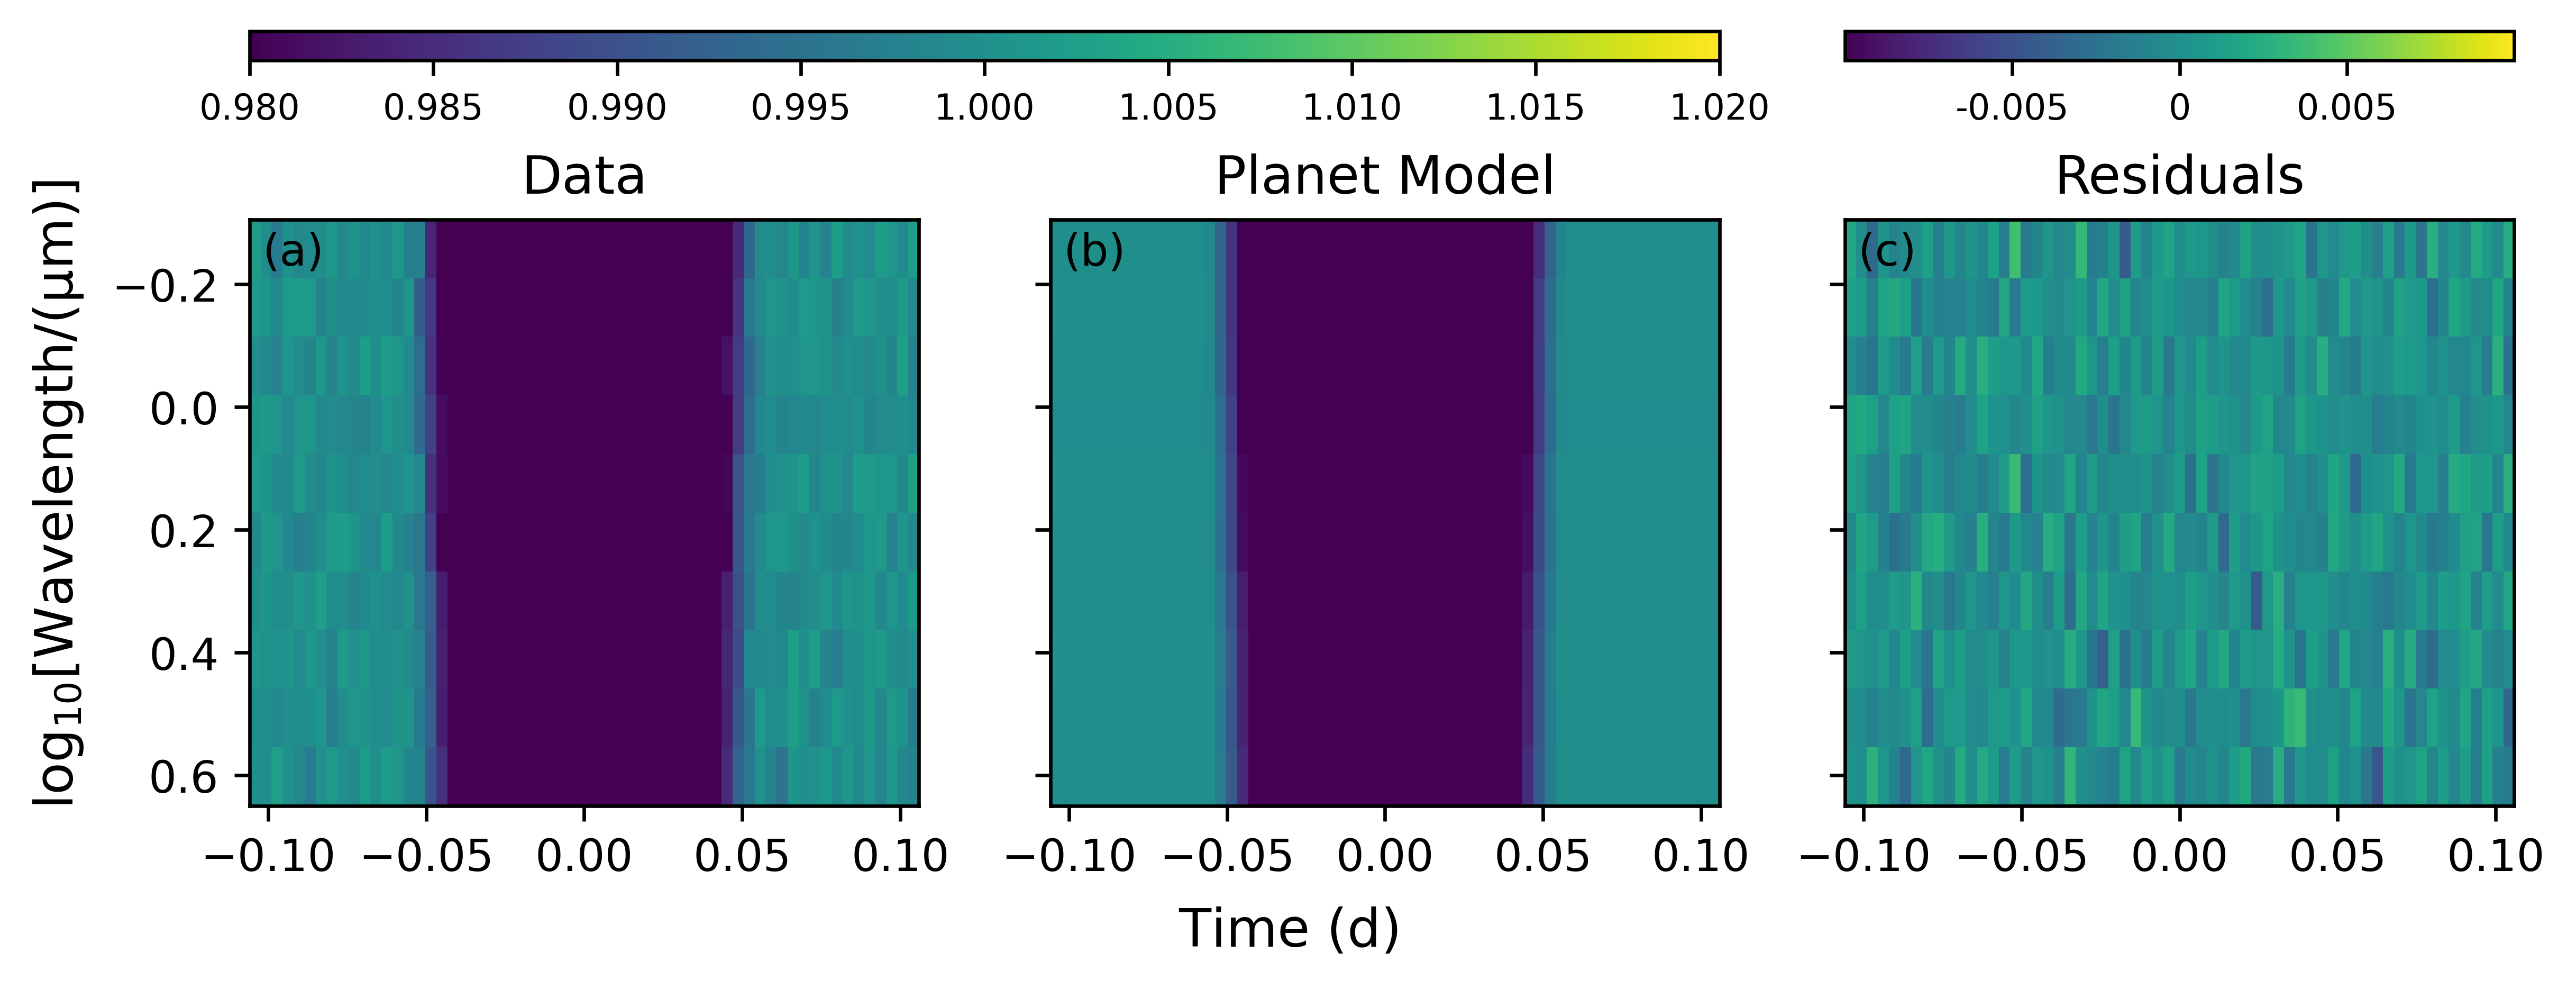

In [62]:
t.imshow_with_models(vspan_residuals=0.01)

## Plot the Transmission Spectrum

We can also plot the transmission spectrum (and we know what the true values are). Here's what we know about the injected transit:

In [63]:
rb.metadata['injected_transit_parameters']

{'rp': array([0.2       , 0.19956522, 0.19913043, 0.19869565, 0.19826087,
        0.19782609, 0.1973913 , 0.19695652, 0.19652174, 0.19608696,
        0.19565217, 0.19521739, 0.19478261, 0.19434783, 0.19391304,
        0.19347826, 0.19304348, 0.1926087 , 0.19217391, 0.19173913,
        0.19130435, 0.19086957, 0.19043478, 0.19      , 0.18956522,
        0.18913043, 0.18869565, 0.18826087, 0.18782609, 0.1873913 ,
        0.18695652, 0.18652174, 0.18608696, 0.18565217, 0.18521739,
        0.18478261, 0.18434783, 0.18391304, 0.18347826, 0.18304348,
        0.1826087 , 0.18217391, 0.18173913, 0.18130435, 0.18086957,
        0.18043478, 0.18      , 0.17956522, 0.17913043, 0.17869565,
        0.17826087, 0.17782609, 0.1773913 , 0.17695652, 0.17652174,
        0.17608696, 0.17565217, 0.17521739, 0.17478261, 0.17434783,
        0.17391304, 0.17347826, 0.17304348, 0.1726087 , 0.17217391,
        0.17173913, 0.17130435, 0.17086957, 0.17043478, 0.17      ,
        0.16956522, 0.16913043, 0.16869565

Plot the transmission spectrum (and in this case we can compare to the original model):

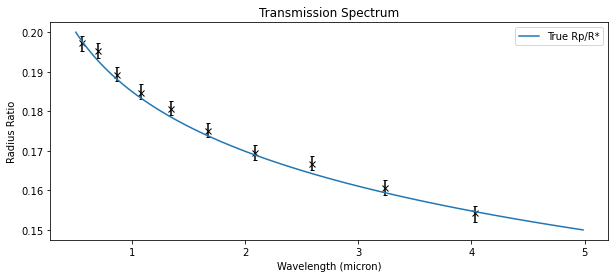

In [64]:
t.plot_transmission_spectrum(uncertainty=['hdi_16%','hdi_84%'])
plt.plot(r.wavelength, rb.metadata['injected_transit_parameters']['rp'], label="True Rp/R*")

plt.legend();

We can also run some diagnostic checks to see the quality of our fit! You might want to check the chi-squared or reduced chi-squared statistic:


For Entire Simultaneous Fit:
Fitted Parameters:
 transit_radius_ratio[0], transit_baseline[0], transit_epoch[0], transit_impact_parameter[0], transit_stellar_radius[0], transit_stellar_mass[0], transit_limb_darkening[0, 0], transit_limb_darkening[0, 1], transit_a_R*[0], transit_planet_radius[0], transit_radius_ratio[1], transit_baseline[1], transit_epoch[1], transit_impact_parameter[1], transit_stellar_radius[1], transit_stellar_mass[1], transit_limb_darkening[1, 0], transit_limb_darkening[1, 1], transit_a_R*[1], transit_planet_radius[1], transit_radius_ratio[2], transit_baseline[2], transit_epoch[2], transit_impact_parameter[2], transit_stellar_radius[2], transit_stellar_mass[2], transit_limb_darkening[2, 0], transit_limb_darkening[2, 1], transit_a_R*[2], transit_planet_radius[2], transit_radius_ratio[3], transit_baseline[3], transit_epoch[3], transit_impact_parameter[3], transit_stellar_radius[3], transit_stellar_mass[3], transit_limb_darkening[3, 0], transit_limb_darkening[3, 1], t

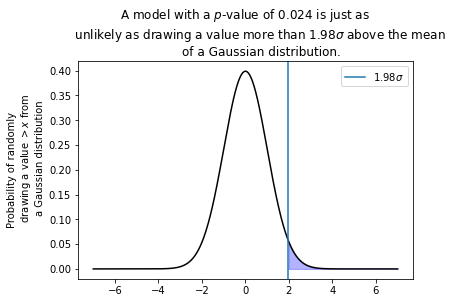

In [65]:
t.chi_squared(plot=True)

Or we can inspect the residual with several different plotting methods:

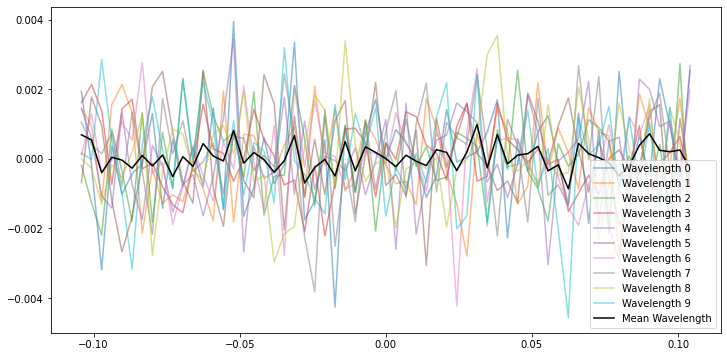

In [66]:
t.plot_residuals()

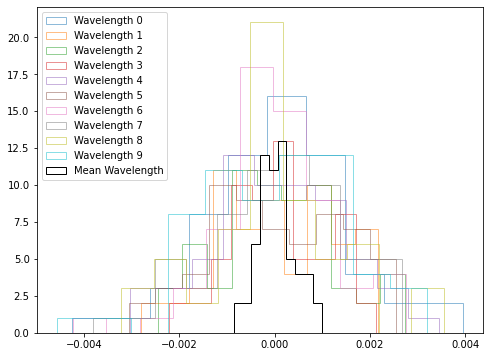

In [67]:
t.plot_residuals_histogram()

For the Wavelength-Averaged Residuals...


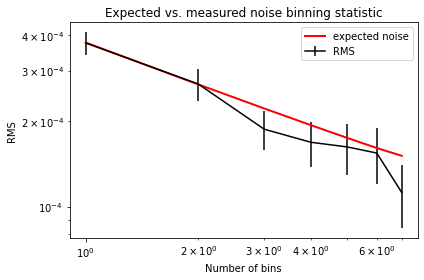

Calculated white noise: 0.0003639 

        Calculated red noise: 9.6843e-05 

        Calculated beta: 1.3408


In [68]:
t.residual_noise_calculator()

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/diagnostics/statistics.py:71: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogx(1 / freq, power)


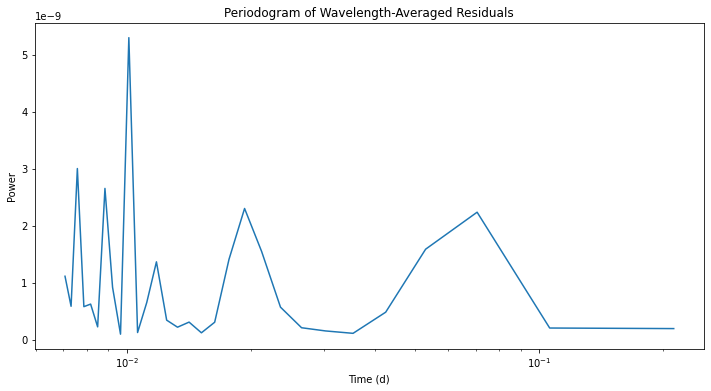

In [69]:
t.plot_residuals_periodogram()